# Import Libraries, Load Data

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
import seaborn as sns
import yfinance as yf
from numpy import linalg as LA
from sklearn.cluster import KMeans
from statsmodels.tsa.stattools import coint
from itertools import combinations
import matplotlib.dates as mdates
from datetime import datetime

In [4]:
# Paths:
price_path = '/Users/tuckeringlefield/Desktop/FinanceData/price_data_from_shardar.csv'
cap_path = '/Users/tuckeringlefield/Desktop/FinanceData/cap_data_from_shardar.csv'
#price_path = "C:/Users/lukee/Downloads/price_data_from_shardar.csv"
#cap_path = "C:/Users/lukee/Downloads/cap_data_from_shardar.csv"

# Reading Data:
prices_df = pd.read_csv(price_path, index_col='date')
caps_df = pd.read_csv(cap_path, index_col='date')

# Drop troubled stock...
prices_df.drop(["MGI", "MDLZ", "DWA", "ICE"], axis=1, inplace=True)
caps_df.drop(["MGI", "MDLZ", "DWA", "ICE"], axis=1, inplace=True)

In [5]:
# Convert dates to datetime
prices_df.index = pd.to_datetime(prices_df.index)

# Get the initial start and end date
start_date = prices_df.index[0]
end_date = prices_df.index[-1]

# Download additional data:
spy_data = yf.download('SPY', start=start_date, end=end_date, interval='1d')
spy_data = pd.DataFrame(spy_data["Adj Close"])
spy_data.rename({"Adj Close": 'SPY'}, inplace=True, axis=1)

# Set up dataframes:
prices_with_market = prices_df.merge(spy_data, how='left', left_index=True, right_index=True)
# df_diff = prices_with_market.diff().dropna()

[*********************100%%**********************]  1 of 1 completed


# Function Definitions

In [6]:
# Function to find the top ten largest market cap stocks
def find_top_liquid_stocks(dataframe, date_start, date_end, num_stocks):
    target_date = date_end + 1
    selected_row = caps_df.iloc[target_date]
    selected_row_no_null = selected_row.dropna()
    stocks_list = selected_row_no_null.nlargest(num_stocks).index.tolist()
    return stocks_list

In [7]:
# Function to filter the DF
def filter_diff_df(dataframe, date_start, date_end, stocks_list):
    desired_columns = stocks_list.copy()
    desired_columns.append("SPY")
    filtered_df = dataframe[desired_columns]
    filtered_df = filtered_df[date_start:date_end].diff()#.dropna()
    filtered_df = filtered_df.dropna()
    return filtered_df

In [8]:
def filter_df_by_dates(dataframe, date_start, date_end, stocks_list):
    desired_columns = stocks_list.copy()
    desired_columns.append("SPY")
    filtered_df = dataframe[desired_columns]
    filtered_df = filtered_df[date_start:date_end]
    return filtered_df

In [9]:
# Function to calculate the residuals
def calculate_residuals(df, stocks_list):
    res_df = pd.DataFrame()
    for stk in stocks_list:
        res_df[stk] = df[stk]-df[stk+"_beta"]*df["SPY"]
    return res_df

In [10]:
# Function to cluster the matrix
def cluster_the_matrix(df, num_clusters):
    A = abs(df.corr().values)
    D = np.diag(A.sum(axis=1))
    L = D - A
    eigenvalues, eigenvectors = LA.eig(L)
    X = eigenvectors[:,:num_clusters]
    kmeans = KMeans(n_clusters=num_clusters, random_state=2, n_init=20).fit(X)

    cluster_dict = {}

    # Iterate over the indices of cluster_list
    for i in range(len(kmeans.labels_)):
        cluster_number = kmeans.labels_[i]
        stock_name = df.columns[i]

        # Check if cluster_number is already a key in the dictionary
        if cluster_number in cluster_dict:
            cluster_dict[cluster_number].append(stock_name)
        else:
            cluster_dict[cluster_number] = [stock_name]

    # Cluster diagram:
    # fig, ax = plt.subplots(1, 1, figsize=(8, 4))
    # scatter = ax.scatter(X[:, 0], X[:, 1], c=kmeans.labels_)
    # unique_labels = {label: idx for idx, label in enumerate(set(kmeans.labels_))}
    # handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=scatter.cmap(scatter.norm(value)), markersize=10)
    #        for value in unique_labels.values()]
    # labels = unique_labels.keys()
    # ax.legend(handles, labels, title="Clusters", loc="best", bbox_to_anchor=(1, 1))
    # ax.set_title(f'K-Means Clustering Results with K={num_clusters}')
    # plt.show()

    return cluster_dict


In [11]:
# Function to find the cointegrated pairs
def find_cointegrated_pairs(dataframe, cluster_dict, sig_level):
    cointegrated_pairs = []
    for cluster_num, stocks in cluster_dict.items():
      for stock1, stock2 in combinations(stocks, 2):
          pvalue1 = coint(dataframe[stock1], dataframe[stock2])[1]
          pvalue2 = coint(dataframe[stock2], dataframe[stock1])[1]
          if pvalue1 < sig_level and pvalue2 < sig_level:
              cointegrated_pairs.append((stock1, stock2))
    return cointegrated_pairs

In [12]:
# Function to check on existing pairs
def is_still_cointegrated(dataframe, pair, sig_level):
    stock1 = pair[0]
    stock2 = pair[1]
    pvalue1 = coint(dataframe[stock1], dataframe[stock2])[1]
    pvalue2 = coint(dataframe[stock2], dataframe[stock1])[1]
    if pvalue1 < sig_level and pvalue2 < sig_level:
        return True
    return False

In [13]:
# weekly function to calculate the beta of the pair
def calculate_beta_for_pair(dataframe, pair):
    asst1 = pair[0]
    asst2 = pair[1]

    train = dataframe[[asst1, asst2]]

    beta = train.cov().iloc[0, 1]/train[asst2].var()
    return beta

In [14]:
# Function to calculate the betas
def calculate_betas(dataframe, date_start, date_end, stocks_list):
    # df = dataframe[date_start:date_end]
    beta_values = []
    columns = []

    df_var = dataframe['SPY'].var()

    for stk in stocks_list:
        df_cov = dataframe[[stk, 'SPY']].cov().loc[stk, 'SPY']
        beta = df_cov / df_var
        beta_values.append(beta)
        columns.append(stk + '_beta')
        
    # print(dataframe[stocks_list])

    beta_df = pd.DataFrame([beta_values], columns=columns)
    beta_df.index = dataframe.index[:1]

    # plt.figure(figsize=(12, 4))
    # sns.boxplot(data=beta_df)
    # plt.show()

    return beta_df

In [15]:
# Function to get the spread data
def get_spread_limits_for_past_months(dataframe, pair, beta):
    asst1 = pair[0]
    asst2 = pair[1]
    asst1_mean = dataframe[asst1].mean() 
    asst2_mean = dataframe[asst2].mean() 
    spread_data = None
    order = []
    if asst1_mean > asst2_mean:
        spread_data = dataframe[asst1]-beta*dataframe[asst2]
        order = [asst1, asst2]
    else:
        spread_data = dataframe[asst2]-beta*dataframe[asst1]
        order = [asst2, asst1]
    mean = spread_data.mean()
    std_dev = spread_data.std()
    lower_limit = mean - (2*std_dev)
    upper_limit = mean + (2*std_dev)
    
    return upper_limit, lower_limit, order, mean

In [16]:
import matplotlib.pyplot as plt

def print_spread_charts(data_series, upper_bound, lower_bound, mean_value, pair_name, pair_dict):
    # Extract dates and values
    dates = data_series.index
    values = data_series.values
    
    # Prepare colors for each point
    colors = []
    close_trade_dates = set(pair_dict['close_trade_dates'])
    open_trade_days = set(date for date, _ in pair_dict['open_trade_dates'])

    for date in dates:
        if date in close_trade_dates:
            print("found close date")
            colors.append('red')
        elif date in open_trade_days:
            print("found open date")
            colors.append('green')
        else:
            colors.append('black')
    
    # Plot the data
    plt.figure(figsize=(10, 6))
    
    # Plot the average line
    plt.axhline(y=mean_value, color='blue', linestyle='-', linewidth=1, label='Mean for Past 3 months')
    
    # Plot the dashed lines for ±2 standard deviations
    plt.axhline(y=upper_bound, color='red', linestyle='--', linewidth=1, label='+2 Std Dev')
    plt.axhline(y=lower_bound, color='red', linestyle='--', linewidth=1, label='-2 Std Dev')
    
    # Plot the individual data points with different colors
    plt.scatter(dates, values, color=colors, zorder=5)
    
    # Annotate the plot
    plt.title(f'Spread data for: {pair_name} for monitoring week')
    plt.xlabel('Date')
    plt.ylabel('Value')
    plt.legend()
    
    # Display the plot
    plt.grid(True)
    plt.show()


In [17]:
def monitor_pair_for_week(stock_price_data, pair, pair_dict, start_date_index, end_date_index, curr_week_start_index, currently_trading_stocks):
    # Get data
    current_week_price_data = stock_price_data[curr_week_start_index : end_date_index] # 7 days of data
    past_three_month_data = stock_price_data[start_date_index : curr_week_start_index]
    have_days_to_trade = False
    
    # If in current trade, use old hedge ratio
    if pair_dict["current_hedge_ratio"] is None:
        # Calculate new hedge ratio
        pair_dict["current_hedge_ratio"] = float(calculate_beta_for_pair(past_three_month_data, pair))

    upper, lower , pair_order, mean_val = get_spread_limits_for_past_months(past_three_month_data, pair, float(pair_dict["current_hedge_ratio"]))
    curr_week_spread_data = current_week_price_data[pair_order[0]]-float(pair_dict["current_hedge_ratio"])*current_week_price_data[pair_order[1]]
    for index, dayValue in zip(curr_week_spread_data.index, curr_week_spread_data.values):
        if len(pair_dict["open_trade_dates"]) > len(pair_dict["close_trade_dates"]):
            if (pair_dict["trade_day_spread_position"] == "upper" and dayValue <= mean_val) or (pair_dict["trade_day_spread_position"] == "lower" and dayValue >= mean_val):
                # Found a closing day
                date = index.strftime('%Y-%m-%d')
                pair_dict["close_trade_dates"].append(date)
                pair_dict["trade_status_message"] = "Looking for trading days"
                pair_dict["trade_day_spread_position"] = "unknown"
                pair_dict["currently_trading"] = False
                have_days_to_trade = True
                # Removed stocks from being traded because they just closed
                currently_trading_stocks.remove(pair[0])
                currently_trading_stocks.remove(pair[1])
        else:
            if dayValue >= upper:
                date = index.strftime('%Y-%m-%d')
                pair_dict["open_trade_dates"].append((date, "Selling spread"))
                pair_dict["trade_status_message"] = "Currently in trade"
                pair_dict["trade_day_spread_position"] = "upper"
                pair_dict["currently_trading"] = True
                have_days_to_trade = True
                # Found a trading day, add to list
                currently_trading_stocks.append(pair[0])
                currently_trading_stocks.append(pair[1])
            elif dayValue <= lower:
                date = index.strftime('%Y-%m-%d')
                pair_dict["open_trade_dates"].append((date, "Buying spread"))
                pair_dict["trade_status_message"] = "Currently in trade"
                pair_dict["trade_day_spread_position"] = "lower"
                pair_dict["currently_trading"] = True
                have_days_to_trade = True    
                # Found a trading day, add to list
                currently_trading_stocks.append(pair[0])
                currently_trading_stocks.append(pair[1])    
                
    # Check if there are open trading days
    if len(pair_dict["open_trade_dates"]) == len(pair_dict["close_trade_dates"]):
        pair_dict["current_hedge_ratio"] = None
    
    # if have_days_to_trade:
    #     print_spread_charts(curr_week_spread_data, upper, lower, mean_val, pair, pair_dict)
    return pair_dict, currently_trading_stocks
    

In [18]:
def monitor_group_of_pairs(stock_price_data, stock_group_size, stop_after_weeks):
    # List of currently trading stocks
    currently_trading_stocks = []
    existing_stocks = {}
    # variable to track the weeks running
    weeks_running = 0
    while (weeks_running < stop_after_weeks):
        print(f"---------------------------- WEEKS RUNNING {weeks_running + 1} -------------------------------------")
        # Calculate index
        start_date_index = ((weeks_running)*7)
        end_date_index = ((weeks_running)*7) + 96
        curr_week_start_index = ((weeks_running)*7) + 89
        # Get data 
        forward_three_months_data = stock_price_data[start_date_index+6 : end_date_index]
        
        # Grab day string to start or stop trades
        curr_week_string = stock_price_data.index[curr_week_start_index].strftime('%Y-%m-%d')
        
        # Loop through existing stocks to find those that should be monitored
        for stock_pair in existing_stocks:
            if existing_stocks[stock_pair]['should_monitor']:
                stock1, stock2 = stock_pair
                if (stock1 not in currently_trading_stocks and stock2 not in currently_trading_stocks) or existing_stocks[stock_pair]["currently_trading"]:
                    # Good to monitor for week    
                    updated_vals, new_currently_trading_stocks = monitor_pair_for_week(stock_price_data, stock_pair, existing_stocks[stock_pair], start_date_index, end_date_index, curr_week_start_index, currently_trading_stocks)
                    existing_stocks[stock_pair] = updated_vals
                    currently_trading_stocks = new_currently_trading_stocks
                else:
                    # Check if this monitoring period was only a day
                    if existing_stocks[stock_pair]["monitoring_start_dates"][-1] == curr_week_string:
                        # remove the start date string
                        existing_stocks[stock_pair]["monitoring_start_dates"].pop()
                    else:
                        existing_stocks[stock_pair]["monitoring_end_dates"].append(curr_week_string)
                        
                    existing_stocks[stock_pair]["should_monitor"] = False
                    existing_stocks[stock_pair]["trade_status_message"] = 'One or more stocks in pair being traded elsewhere'
                
        # Setup for next week
        highly_liquid_stocks = find_top_liquid_stocks(stock_price_data, (start_date_index+7) , (end_date_index), stock_group_size)

        # Grab day string to start or stop trades
        end_date_string = stock_price_data.index[end_date_index].strftime('%Y-%m-%d')
              
        # Remove all liquid stocks that have null data      
        liquid_stocks_not_null = []
        for stock in highly_liquid_stocks:
            num_nulls_for_stock = forward_three_months_data[stock].isnull().sum().item()
            if num_nulls_for_stock == 0:
                liquid_stocks_not_null.append(stock)       
                
        # Find pairs clustered together this week
        diff_df = filter_diff_df(stock_price_data, (start_date_index+7) , (end_date_index), liquid_stocks_not_null)
        three_month_highly_liquid_stocks_price_df = filter_df_by_dates(stock_price_data, (start_date_index+6) , end_date_index, liquid_stocks_not_null)
        beta_df = calculate_betas(diff_df, (start_date_index+6) , end_date_index, liquid_stocks_not_null)

        merged_df = diff_df.merge(beta_df, how = 'cross')
        res_df = calculate_residuals(merged_df, liquid_stocks_not_null)
        cluster_dict = cluster_the_matrix(res_df, 5)
        clustered_stock_pairs = find_cointegrated_pairs(three_month_highly_liquid_stocks_price_df, cluster_dict, 0.05)
        
        # Handle Existing pairs
        for stock_pair in existing_stocks:
            # Destructure to check ordering
            stock1, stock2 = stock_pair
            # Checking existing pairs if they were clustered together again
            if (stock1, stock2) in clustered_stock_pairs or (stock2, stock1) in clustered_stock_pairs:
                if existing_stocks[stock_pair]["should_monitor"]:
                    # Check if stock pair is not currently trading, and if trades are happening elsewhere
                    if not existing_stocks[stock_pair]["currently_trading"] and (stock1 in currently_trading_stocks or stock2 in currently_trading_stocks):
                        # Can't monitor anymore, stocks in trade elsewhere
                        existing_stocks[stock_pair]["should_monitor"] = False
                        existing_stocks[stock_pair]["trade_status_message"] = 'One or more stocks in pair being traded elsewhere'
                        existing_stocks[stock_pair]["monitoring_end_dates"].append(end_date_string)            
                else:
                    # Check if stocks being traded elsewhere
                    if stock1 not in currently_trading_stocks and stock2 not in currently_trading_stocks:
                        # Good to start monitoring
                        existing_stocks[stock_pair]["should_monitor"] = True
                        existing_stocks[stock_pair]["trade_status_message"] = 'Looking for trading days'
                        existing_stocks[stock_pair]["monitoring_start_dates"].append(end_date_string)
                    else:
                        # Can't monitor due to stocks being traded elsewhere
                        existing_stocks[stock_pair]["trade_status_message"] = 'One or more stocks in pair being traded elsewhere'           
            else:
                # Check if stock was previously being monitored
                if existing_stocks[stock_pair]["should_monitor"]:
                    # Check if stocks were being traded
                    if existing_stocks[stock_pair]["currently_trading"]:
                        # Close trades
                        existing_stocks[stock_pair]["close_trade_dates"].append(end_date_string)
                        # Remove from trading list
                        currently_trading_stocks.remove(stock1)
                        currently_trading_stocks.remove(stock2)
                    
                    # End monitoring period
                    existing_stocks[stock_pair]["monitoring_end_dates"].append(end_date_string)
                
                # Update fields in stock pair dictionary
                existing_stocks[stock_pair]["should_monitor"] = False
                existing_stocks[stock_pair]["is_cointegrated"] = False
                existing_stocks[stock_pair]["trade_status_message"] = 'Stocks are not in the same cluster'
                existing_stocks[stock_pair]["current_hedge_ratio"] = None
                existing_stocks[stock_pair]["trade_day_spread_position"] = 'unknown'
                existing_stocks[stock_pair]["currently_trading"] = False
                
        # Handle adding new pairs
        for stock_pair in clustered_stock_pairs:
            # Destructure to check not in existing
            stock1, stock2 = stock_pair
            if ((stock1, stock2) not in existing_stocks and (stock2, stock1) not in existing_stocks) and (stock1 not in currently_trading_stocks and stock2 not in currently_trading_stocks):
                # Start monitoring and add to list
                existing_stocks[stock_pair] = {
                    "is_cointegrated" : True,
                    "should_monitor" : True,
                    "trade_status_message" : "Looking for trading days",
                    "monitoring_start_dates" : [end_date_string],
                    "monitoring_end_dates" : [],
                    "open_trade_dates" : [],
                    "close_trade_dates" : [],
                    "trade_day_spread_position": "unknown",
                    "current_hedge_ratio": None,
                    "currently_trading": False
                }
                    
        # Increment weeks_running
        weeks_running +=1

    return existing_stocks, end_date_string
        

In [64]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime
import pprint

def print_overall_display(pairs_dictionary):
    data = pairs_dictionary

    # Function to convert date strings to datetime objects
    def str_to_date(date_str):
        return datetime.strptime(date_str, '%Y-%m-%d')

    # Filter out keys with no periods or events
    filtered_data = {
        key: value for key, value in data.items()
        if (value['monitoring_start_dates'] or value['monitoring_end_dates'] or
            value['open_trade_dates'] or value['close_trade_dates'])
    }

    num_pairs = len(filtered_data)
    num_needed_plots = 0
    if num_pairs%20 != 0:
        num_needed_plots = num_pairs//20 + 1
    else:
        num_needed_plots = num_pairs//20
    # Sort the pairs into chunks for printing 
    indexing_var = 0
    keys = list(filtered_data.keys())
    print(keys)
    plotting_dict = {}
    for plot in range(num_needed_plots):
        plotting_dict[f'Plot_{plot+1}'] = []
        for j in range(20):
            if indexing_var == num_pairs-1:
                continue
            plotting_dict[f'Plot_{plot+1}'].append(keys[indexing_var])
            indexing_var +=1
    
    #pprint.pprint(plotting_dict)

    # Iterate over the plotting_dict to create plots
    for plot_name, pairs in plotting_dict.items():
        fig, ax = plt.subplots(figsize=(15, 10))  # Adjust the size as needed
        print(f"Creating {plot_name} with pairs: {pairs}")

        # Get the data for the current set of pairs
        chunk_data = [(key, filtered_data[key]) for key in pairs if key in filtered_data]

        # Iterate over the chunk data to plot
        for idx, (key, value) in enumerate(chunk_data):
            label = f"{key[0]}-{key[1]}"

            # Extract periods
            periods_start = [str_to_date(date) for date in value['monitoring_start_dates']]
            periods_end = [str_to_date(date) for date in value['monitoring_end_dates']]

            # Extract event dates
            open_trade_dates = [str_to_date(date[0]) for date in value['open_trade_dates']]
            close_trade_dates = [str_to_date(date) for date in value['close_trade_dates']]

            # Plot each period as a line
            for start, end in zip(periods_start, periods_end):
                ax.plot([start, end], [idx, idx], color='black')

            # Plot open trade dates as green dots
            if open_trade_dates:
                ax.plot(open_trade_dates, [idx] * len(open_trade_dates), 'o', color='green', label='Open Trade Dates' if idx == 0 else "")

            # Plot close trade dates as red dots
            if close_trade_dates:
                ax.plot(close_trade_dates, [idx] * len(close_trade_dates), 'o', color='red', label='Close Trade Dates' if idx == 0 else "")

        # Formatting the plot
        y_labels = [f"{key[0]}-{key[1]}" for key, _ in chunk_data]
        if y_labels:
            ax.set_yticks(range(len(y_labels)))
            ax.set_yticklabels(y_labels, fontsize=10, horizontalalignment='right')

        ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
        plt.xticks(rotation=45)
        plt.xlabel('Date')
        plt.title(f'Event Timelines for {plot_name}')
        plt.legend()
        plt.tight_layout()
        plt.show()


In [72]:
def construct_periods(start_dates, end_dates):
    periods = []

    min_length = min(len(start_dates), len(end_dates))

    # Pair each start date with the corresponding end date
    for i in range(min_length):
        periods.append((start_dates[i], end_dates[i]))

    # Handle cases where the lists are of unequal length
    if len(start_dates) > len(end_dates):
        # If there are more start dates, pair the remaining ones with None (or a placeholder)
        for j in range(min_length, len(start_dates)):
            periods.append((start_dates[j], None))
    elif len(end_dates) > len(start_dates):
        # If there are more end dates, pair the remaining ones with the last start date
        for j in range(min_length, len(end_dates)):
            periods.append((start_dates[-1], end_dates[j]))

    return periods

# function to print open/close days with prices
def print_trading_with_prices(dict, end_date):
    global prices_with_market
    
    # Function to convert date strings to datetime objects
    def str_to_date(date_str):
        return datetime.strptime(date_str, '%Y-%m-%d')

    # Filter out keys with no periods or events
    filtered_data = {
        key: value for key, value in dict.items()
        if (value['monitoring_start_dates'] or value['monitoring_end_dates'] or
            value['open_trade_dates'] or value['close_trade_dates'])
    }
    
    
    for key in filtered_data:
        open_trade_dates = []
        for item in filtered_data[key]['open_trade_dates']:
            date = item[0]
            open_trade_dates.append(date)
        close_trade_dates = filtered_data[key]['close_trade_dates']
        if len(open_trade_dates) == 0:
            continue
        #plot the pair
        if len(open_trade_dates) > 1:
            plot_start_date = open_trade_dates[0]
            plot_end_date = close_trade_dates[-1]
        else:
            # need to move the dates a month behind and head, respectively
            trade_start_loc = prices_with_market.index.get_loc(open_trade_dates[0])
            plot_start_loc = trade_start_loc - 14
            if plot_start_loc < 0:
                plot_start_loc = 0
            plot_start_date = prices_with_market.index[plot_start_loc]
            trade_end_loc = prices_with_market.index.get_loc(close_trade_dates[-1])
            plot_end_loc = trade_end_loc + 14
            # need to impliment some sort of out of range check for this in the future...
            plot_end_date = prices_with_market.index[plot_end_loc]
        prices_with_market[[key[0], key[1]]][plot_start_date:plot_end_date].plot()
        plt.title(f"{key}")
        # Add vertical green lines for open_trade_dates
        for date in open_trade_dates:
            plt.axvline(x=date, color='green', linestyle='--', linewidth=1)
        # Add vertical red lines for close_trade_dates
        for date in close_trade_dates:
            plt.axvline(x=date, color='red', linestyle='--', linewidth=1)
        plt.show()
        

In [80]:
import matplotlib.pyplot as plt
import pandas as pd

def print_spread_with_trading_charts(data_dict, end_date):
    global prices_with_market
    for key in data_dict:
        if not data_dict[key]['open_trade_dates'] or not data_dict[key]['monitoring_start_dates']:
            continue
        
        monitoring_start_dates = data_dict[key]['monitoring_start_dates']
        monitoring_end_dates = data_dict[key]['monitoring_end_dates']
        open_trade_dates = [day[0] for day in data_dict[key]['open_trade_dates']]
        close_trade_dates = data_dict[key]['close_trade_dates']
        
        stock1, stock2 = key
        periods = construct_periods(open_trade_dates,close_trade_dates)
        
        for period in periods:
            spread_start_date = period[0]
            spread_end_date = period[1] if len(period) > 1 else end_date
            
            
            position_1 = prices_with_market.index.get_loc(spread_start_date)
            start_position = max(0, position_1 - 89)
            past_three_months_all_data = prices_with_market.iloc[start_position:position_1 + 1]
            past_three_months_data = past_three_months_all_data[[stock1, stock2]]
                
            beta = calculate_beta_for_pair(past_three_months_data, key)
            upper, lower, pair_order, mean_val = get_spread_limits_for_past_months(past_three_months_data, key, beta)
                
            price_data = prices_with_market[[stock1, stock2]].loc[spread_start_date:spread_end_date]
            spread_data = price_data[pair_order[0]] - beta * price_data[pair_order[1]]
            dates = spread_data.index
            values = spread_data.values

            # # Determine color for each date
            # colors = []
            # for date in dates:            
            #     if date_str in open_trade_dates:
            #         colors.append('green')
            #     elif date_str in close_trade_dates:
            #         colors.append('red')
            #     else:
            #         colors.append('black')
            colors = 'black'

            # Plot the data
            plt.figure(figsize=(10, 6))
            plt.axhline(y=mean_val, color='blue', linestyle='-', linewidth=1, label='Mean for Past 3 months')
            plt.axhline(y=upper, color='red', linestyle='--', linewidth=1, label='+2 Std Dev')
            plt.axhline(y=lower, color='red', linestyle='--', linewidth=1, label='-2 Std Dev')
            plt.scatter(dates, values, c=colors)
            # is there a way to give a better message here?...
            plt.title(f"Spread data for: {key} for trade: {period} Message: {data_dict[key]['trade_status_message']}")
            plt.xlabel('Date')
            plt.ylabel('Value')
            plt.legend()
            plt.grid(True)
            plt.show()
                

In [22]:
def print_all_visualizations(dict, end_date):
    print_overall_display(dict)
    print_trading_with_prices(dict, end_date)
    print_spread_with_trading_charts(dict, end_date)


# Running Functions

In [40]:
# results = monitor_group_of_pairs(coint_dict, 5)
import pprint
results, end_date = monitor_group_of_pairs(prices_with_market, 20,30)
pprint.pprint(results)

---------------------------- WEEKS RUNNING 1 -------------------------------------
---------------------------- WEEKS RUNNING 2 -------------------------------------
---------------------------- WEEKS RUNNING 3 -------------------------------------
---------------------------- WEEKS RUNNING 4 -------------------------------------
---------------------------- WEEKS RUNNING 5 -------------------------------------
---------------------------- WEEKS RUNNING 6 -------------------------------------
---------------------------- WEEKS RUNNING 7 -------------------------------------
---------------------------- WEEKS RUNNING 8 -------------------------------------
---------------------------- WEEKS RUNNING 9 -------------------------------------
---------------------------- WEEKS RUNNING 10 -------------------------------------
---------------------------- WEEKS RUNNING 11 -------------------------------------
---------------------------- WEEKS RUNNING 12 -------------------------------------
-

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


[('SCMR', 'VIAV'), ('ORCL', 'INTC'), ('ORCL', 'AMAT'), ('CIEN', 'SDLI'), ('SDLI', 'SEBL'), ('PMCS', 'BRCD'), ('CTXS', 'LVLT'), ('LVLT', 'HLIT'), ('RMBS', 'PMCS'), ('LVLT', 'AKAM'), ('LVLT', 'ARBA'), ('YHOO', 'EXDS'), ('ORCL', 'NRTLQ'), ('JNPR', 'VIAV'), ('JNPR', 'BRCD'), ('RMBS', 'BRCD'), ('JAVA1', 'ORCL'), ('SCMR', 'INTC'), ('JAVA1', 'LVLT'), ('INTC', 'NRTLQ'), ('CSCO', 'EXDS'), ('INTC', 'JNPR'), ('SCMR', 'SDLI'), ('CMVT', 'MU'), ('SCMR', 'NRTLQ'), ('JNPR', 'GLW'), ('NRTLQ', 'SDLI'), ('INTC', 'QCOM'), ('ARBA', 'EMC1'), ('CSCO', 'INTC'), ('JNPR', 'ITWO'), ('CIEN', 'BEAS'), ('AMCC', 'EMC1'), ('SCMR', 'CSCO'), ('VIAV', 'VRTS1'), ('CIEN', 'ITWO'), ('SEBL', 'VRTS1'), ('JAVA1', 'PMCS'), ('JAVA1', 'ARBA'), ('BRCD', 'SEBL'), ('SDLI', 'VIAV'), ('VRTS1', 'BRCD'), ('ORCL', 'SDLI'), ('ORCL', 'AMCC'), ('JAVA1', 'EMC1'), ('LVLT', 'AMCC'), ('CSCO', 'EMC1'), ('JAVA1', 'VRTS1'), ('JNPR', 'BRCM'), ('VIAV', 'CIEN'), ('VIAV', 'PMCS'), ('SEBL', 'EMC1'), ('LVLT', 'AMAT'), ('JNPR', 'VRTS1'), ('JNPR', 'NTAP'

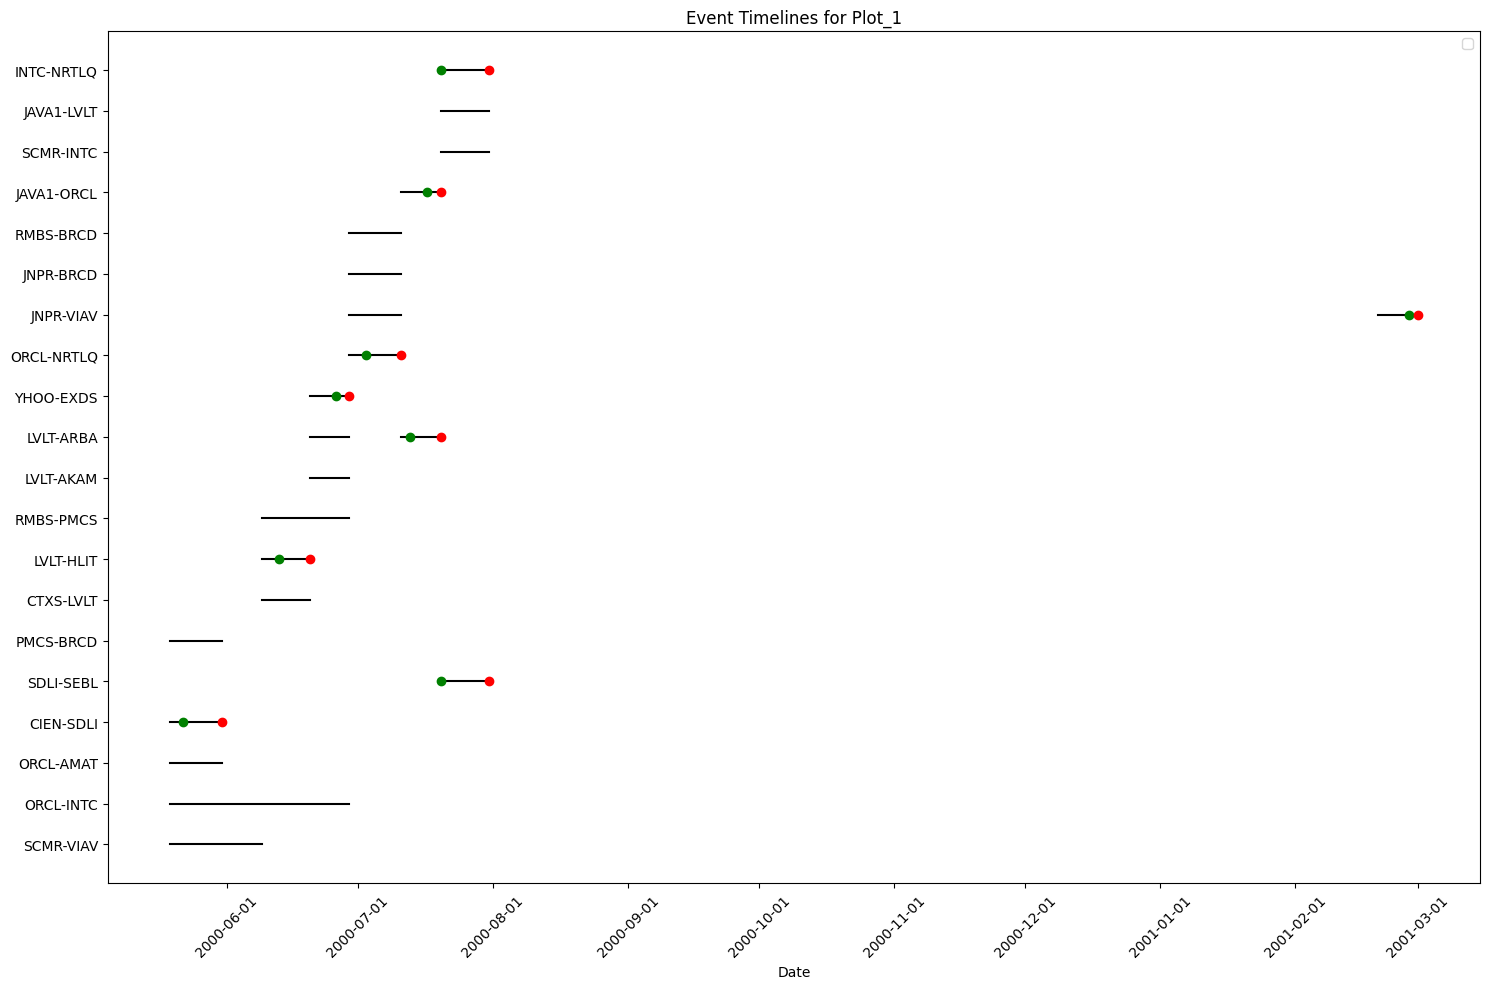

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Creating Plot_2 with pairs: [('CSCO', 'EXDS'), ('INTC', 'JNPR'), ('SCMR', 'SDLI'), ('CMVT', 'MU'), ('SCMR', 'NRTLQ'), ('JNPR', 'GLW'), ('NRTLQ', 'SDLI'), ('INTC', 'QCOM'), ('ARBA', 'EMC1'), ('CSCO', 'INTC'), ('JNPR', 'ITWO'), ('CIEN', 'BEAS'), ('AMCC', 'EMC1'), ('SCMR', 'CSCO'), ('VIAV', 'VRTS1'), ('CIEN', 'ITWO'), ('SEBL', 'VRTS1'), ('JAVA1', 'PMCS'), ('JAVA1', 'ARBA'), ('BRCD', 'SEBL')]


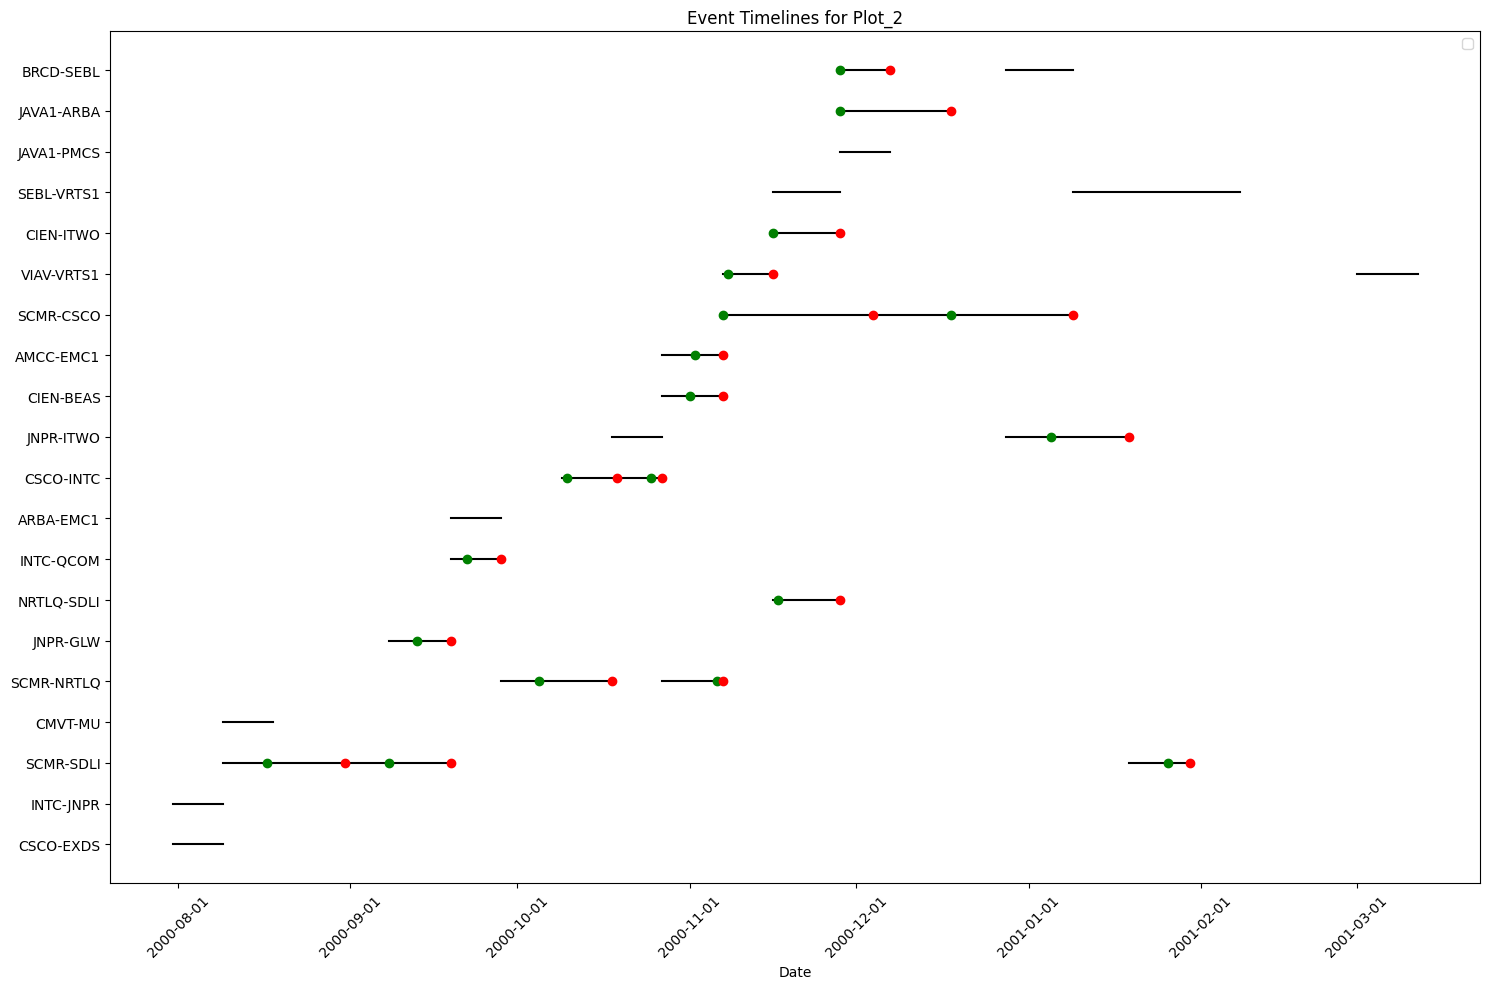

Creating Plot_3 with pairs: [('SDLI', 'VIAV'), ('VRTS1', 'BRCD'), ('ORCL', 'SDLI'), ('ORCL', 'AMCC'), ('JAVA1', 'EMC1'), ('LVLT', 'AMCC'), ('CSCO', 'EMC1'), ('JAVA1', 'VRTS1'), ('JNPR', 'BRCM'), ('VIAV', 'CIEN'), ('VIAV', 'PMCS'), ('SEBL', 'EMC1'), ('LVLT', 'AMAT'), ('JNPR', 'VRTS1'), ('JNPR', 'NTAP'), ('SDLI', 'EMC1'), ('NTAP', 'BRCM'), ('BRCM', 'VRTS1'), ('JAVA1', 'SEBL'), ('VRTS1', 'ITWO')]


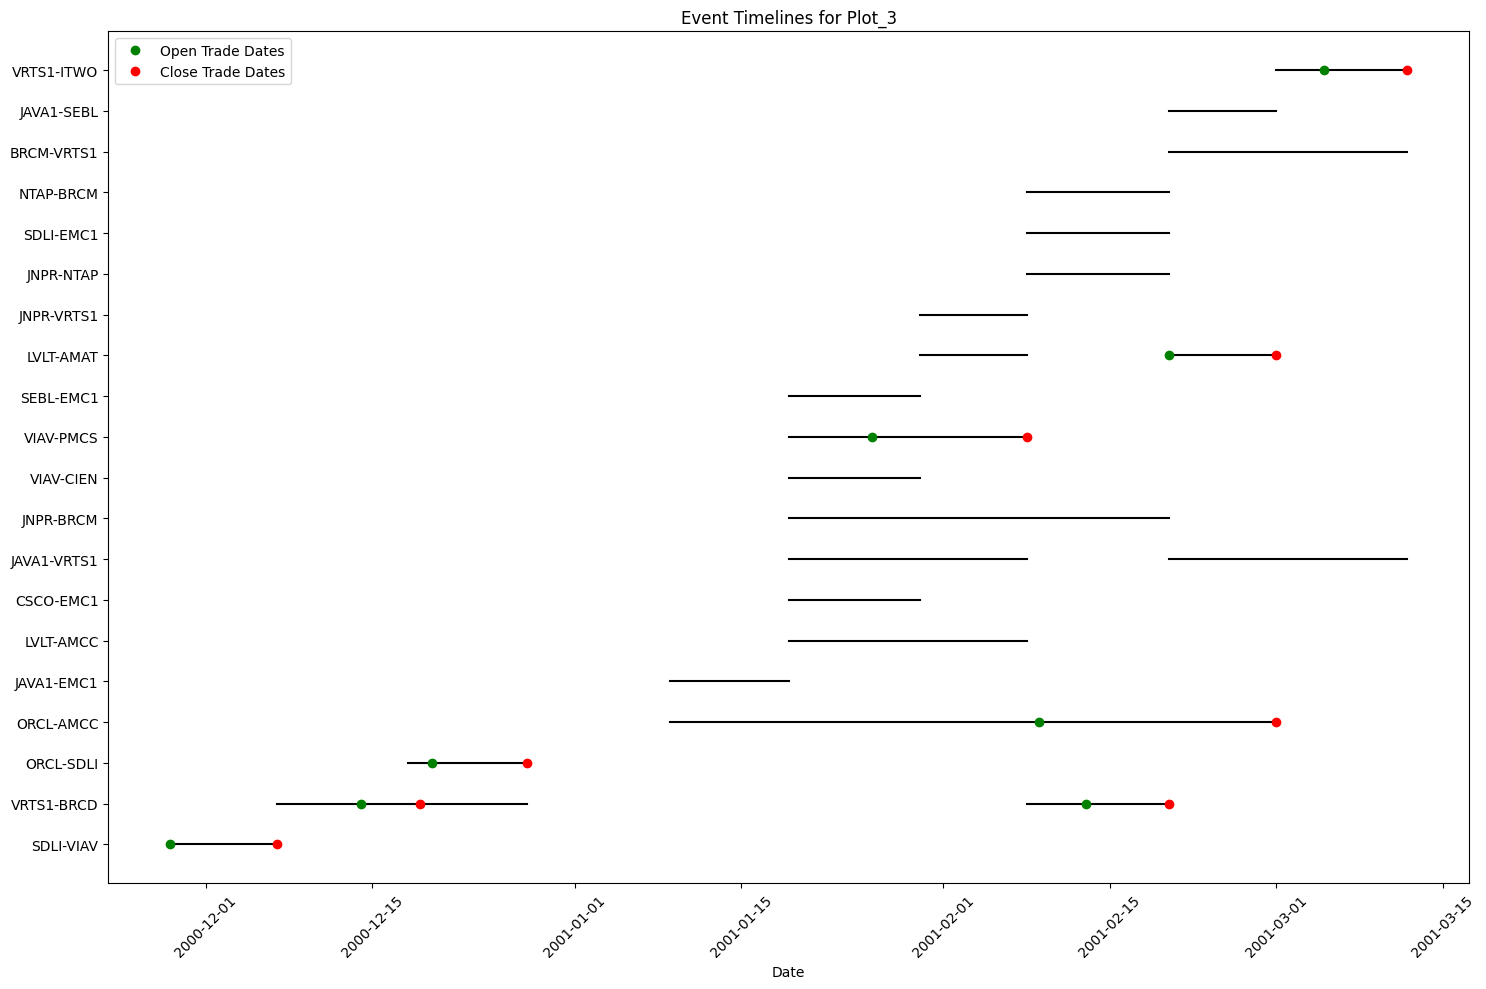

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Creating Plot_4 with pairs: [('LVLT', 'CMVT')]


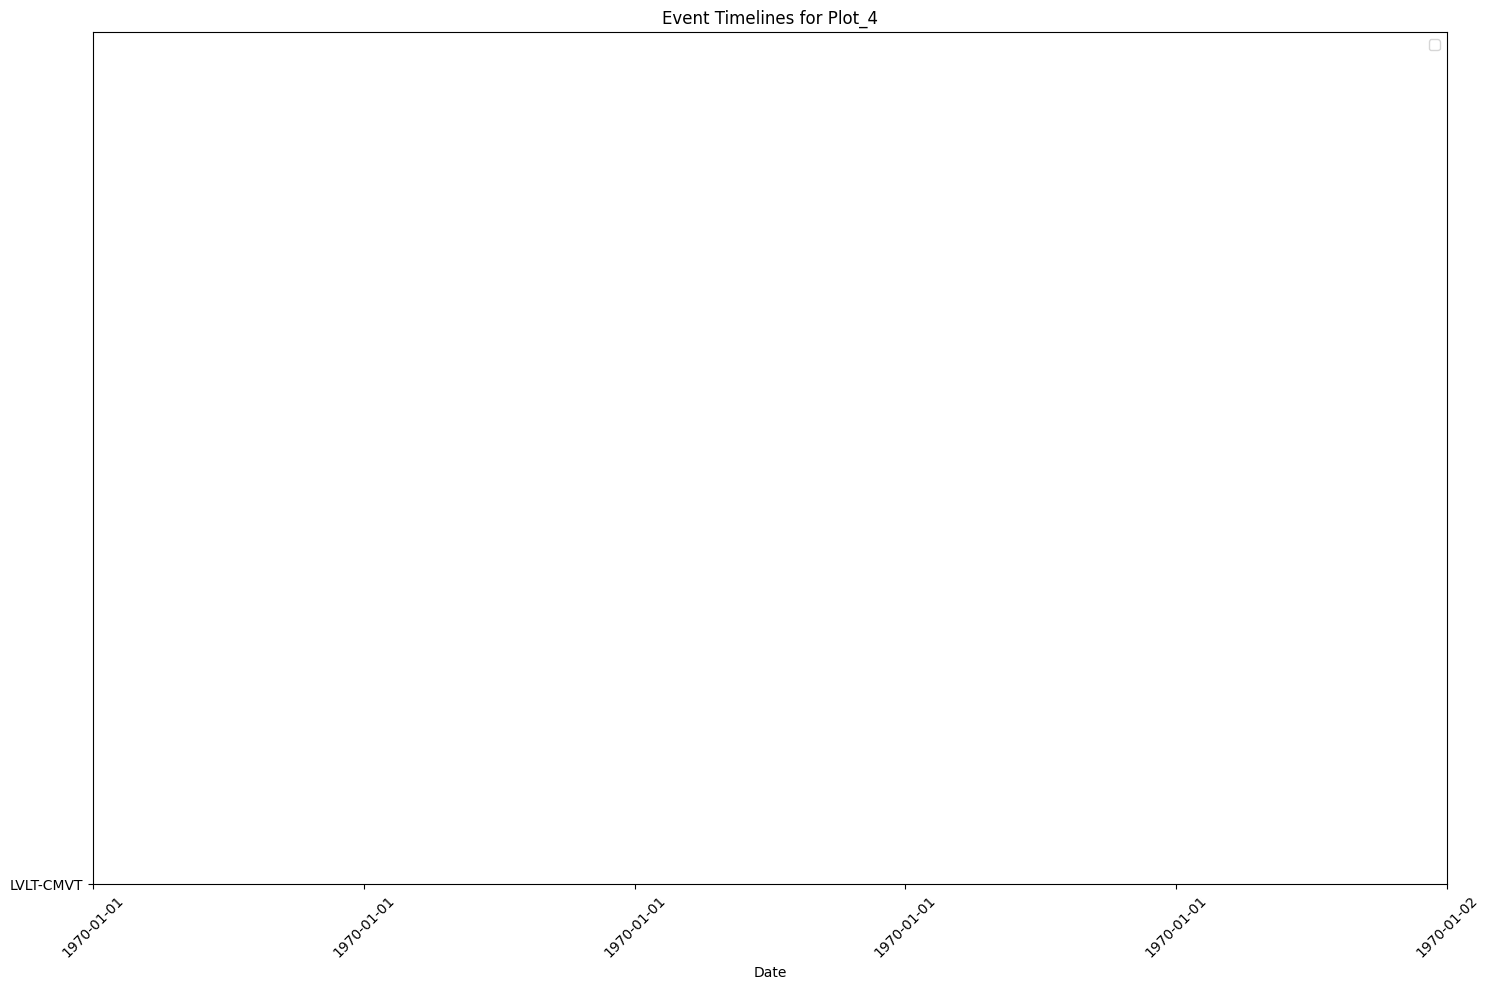

-------------- Finding Periods for Price Data ----------------
83
2000-05-22
2000-05-31
117


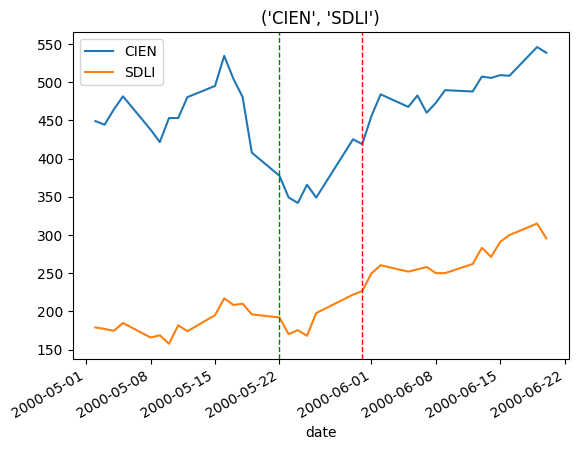

-------------- Finding Periods for Price Data ----------------
124
2000-07-20
2000-07-31
159


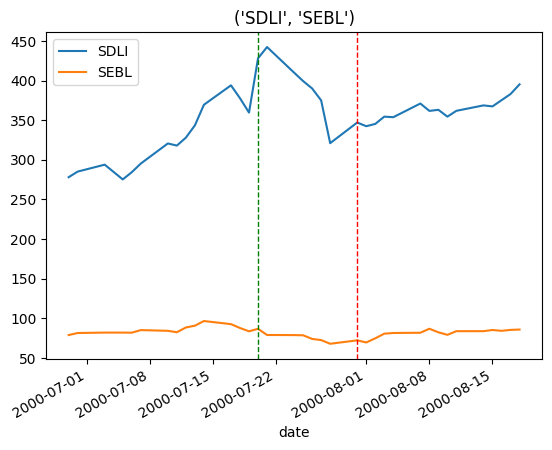

-------------- Finding Periods for Price Data ----------------
98
2000-06-13
2000-06-20
131


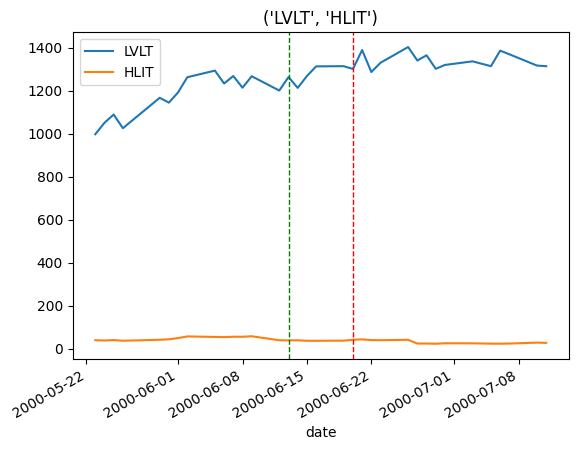

-------------- Finding Periods for Price Data ----------------
119
2000-07-13
2000-07-20
152


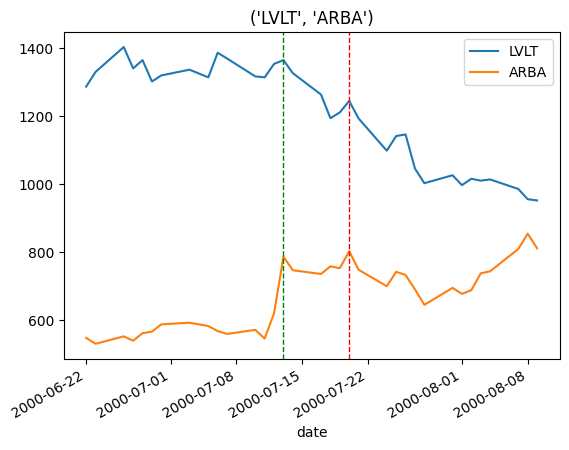

-------------- Finding Periods for Price Data ----------------
107
2000-06-26
2000-06-29
138


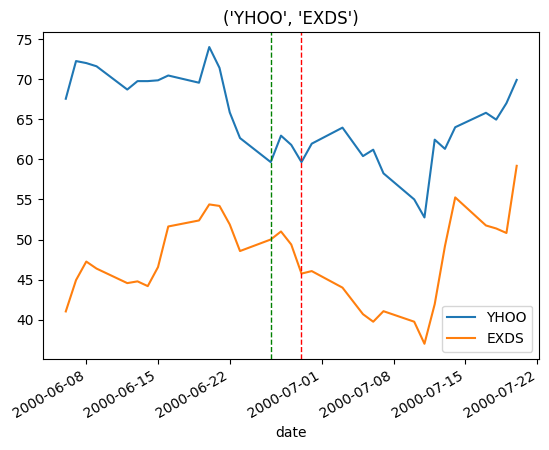

-------------- Finding Periods for Price Data ----------------
112
2000-07-03
2000-07-11
145


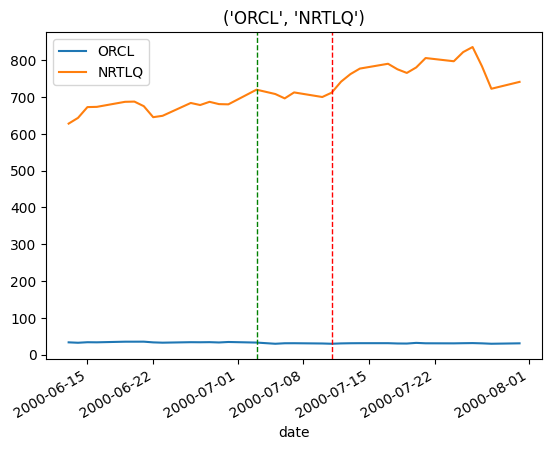

-------------- Finding Periods for Price Data ----------------
276
2001-02-27
2001-03-01
306


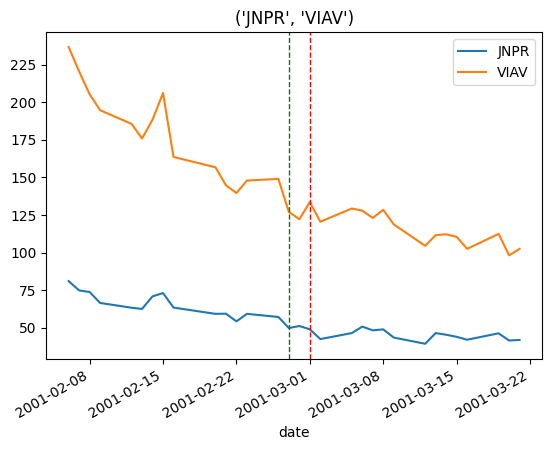

-------------- Finding Periods for Price Data ----------------
121
2000-07-17
2000-07-20
152


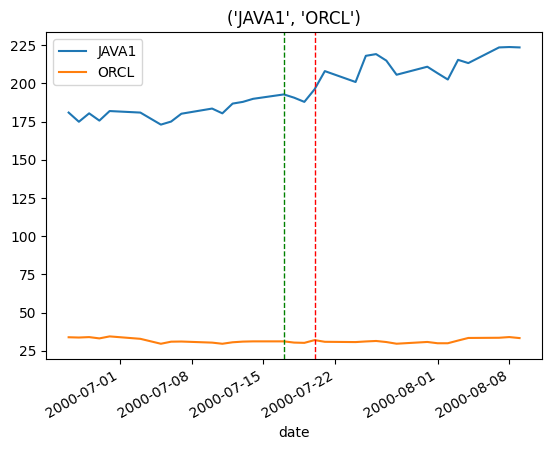

-------------- Finding Periods for Price Data ----------------
124
2000-07-20
2000-07-31
159


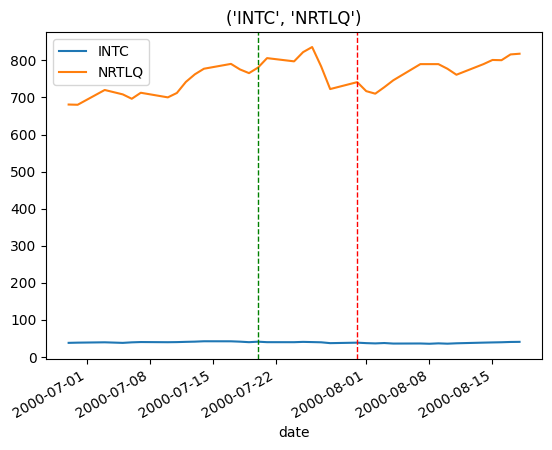

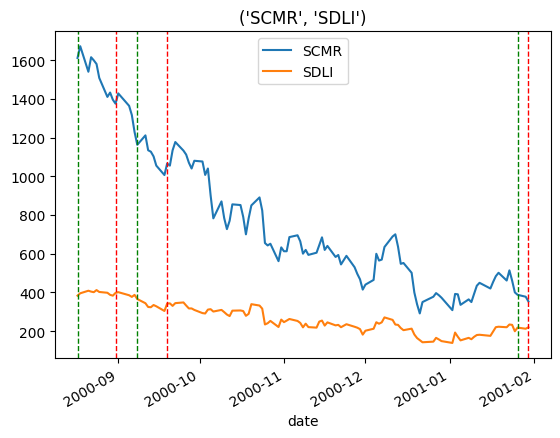

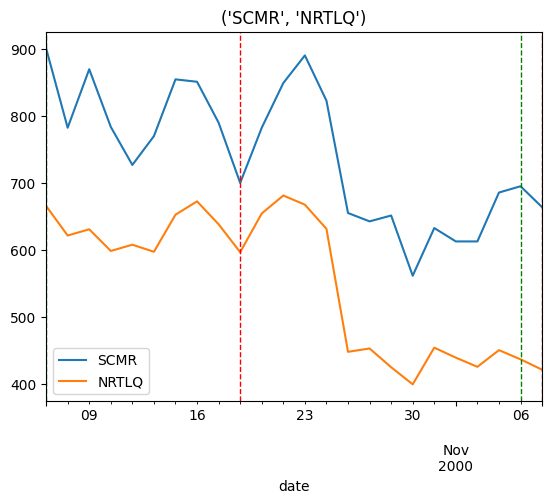

-------------- Finding Periods for Price Data ----------------
162
2000-09-13
2000-09-19
194


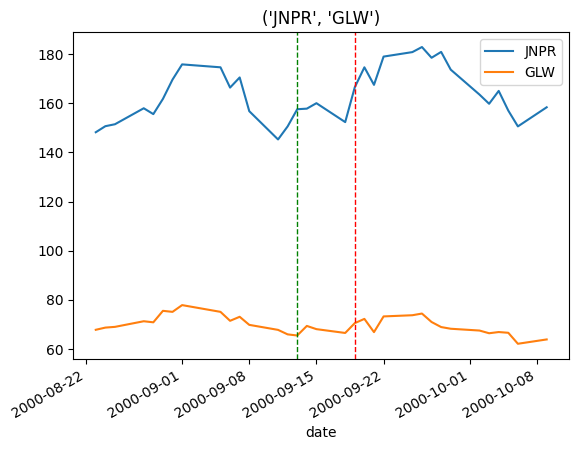

-------------- Finding Periods for Price Data ----------------
209
2000-11-17
2000-11-28
243


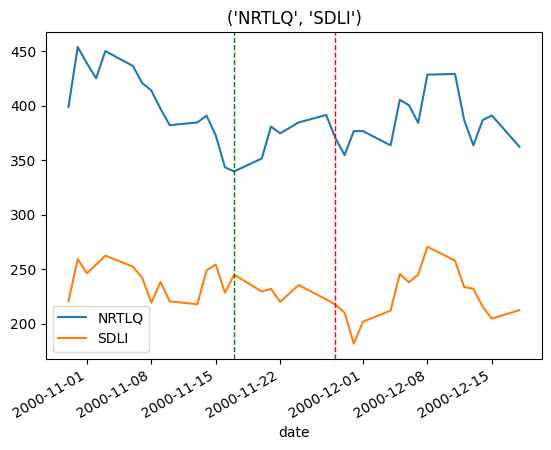

-------------- Finding Periods for Price Data ----------------
169
2000-09-22
2000-09-28
201


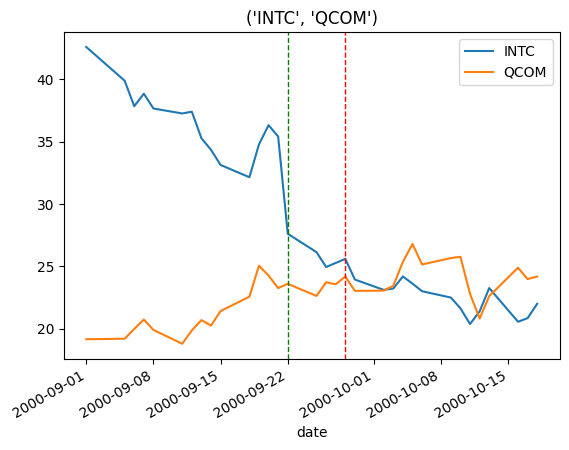

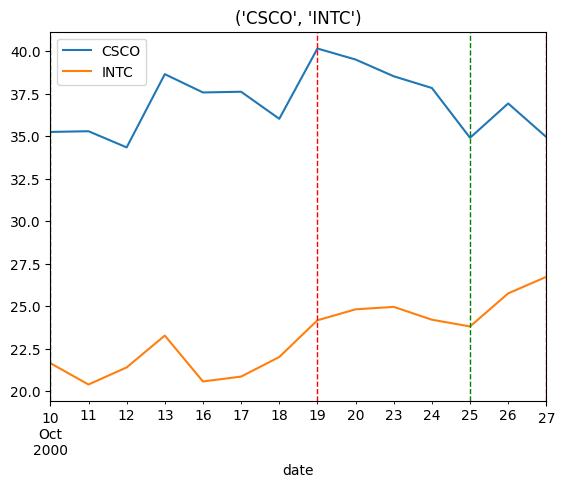

-------------- Finding Periods for Price Data ----------------
241
2001-01-05
2001-01-19
278


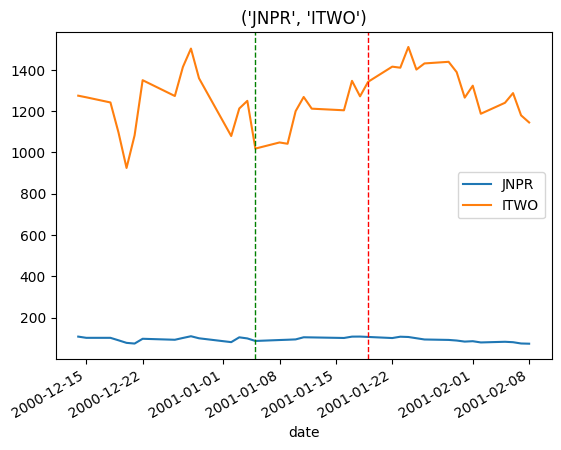

-------------- Finding Periods for Price Data ----------------
197
2000-11-01
2000-11-07
229


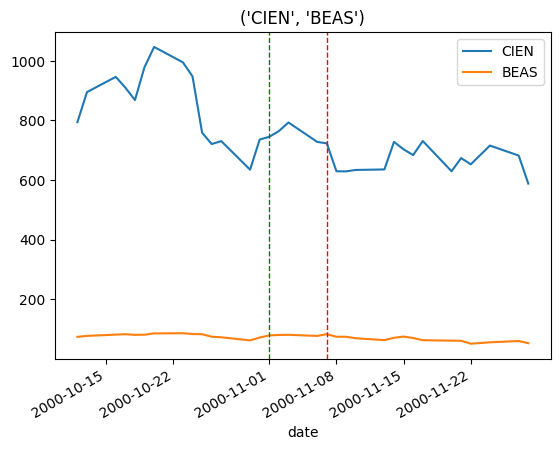

-------------- Finding Periods for Price Data ----------------
198
2000-11-02
2000-11-07
229


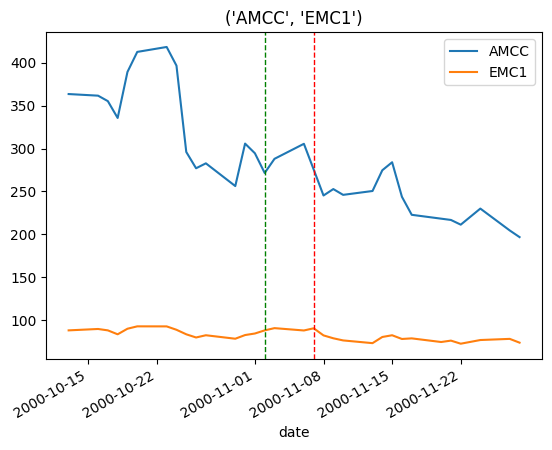

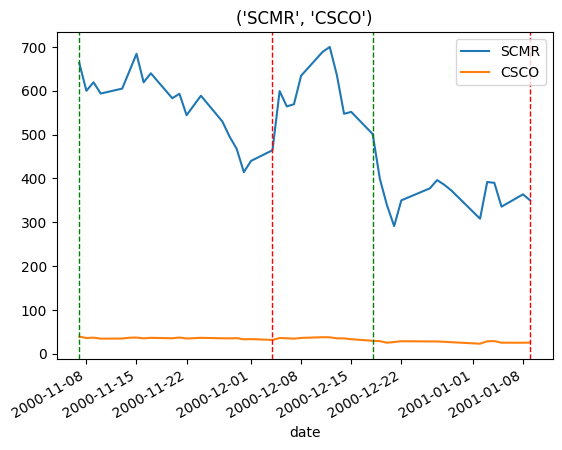

-------------- Finding Periods for Price Data ----------------
202
2000-11-08
2000-11-16
236


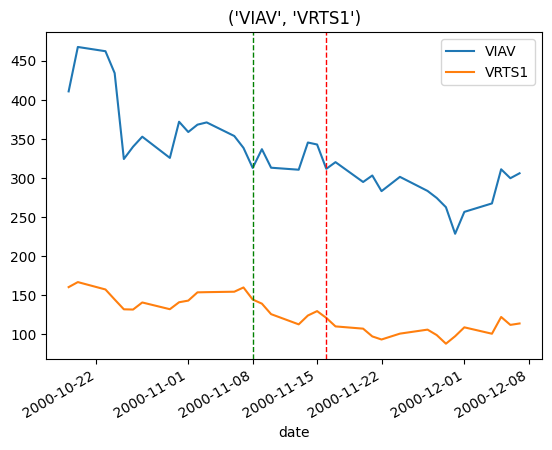

-------------- Finding Periods for Price Data ----------------
208
2000-11-16
2000-11-28
243


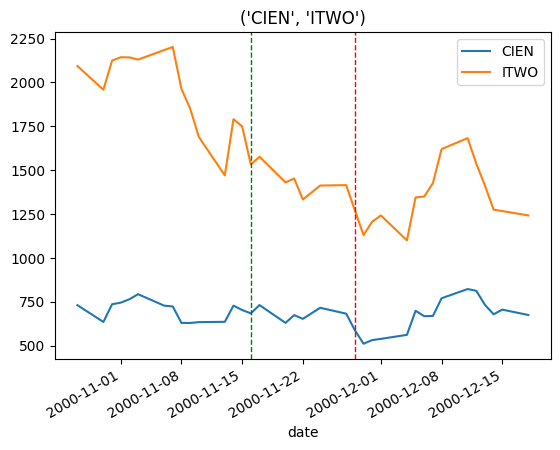

-------------- Finding Periods for Price Data ----------------
215
2000-11-28
2000-12-18
257


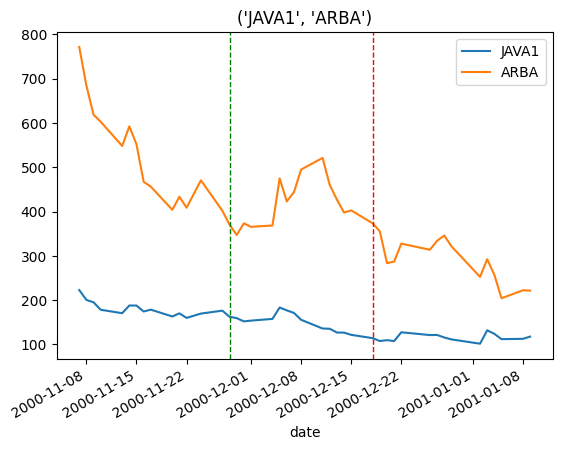

-------------- Finding Periods for Price Data ----------------
215
2000-11-28
2000-12-07
250


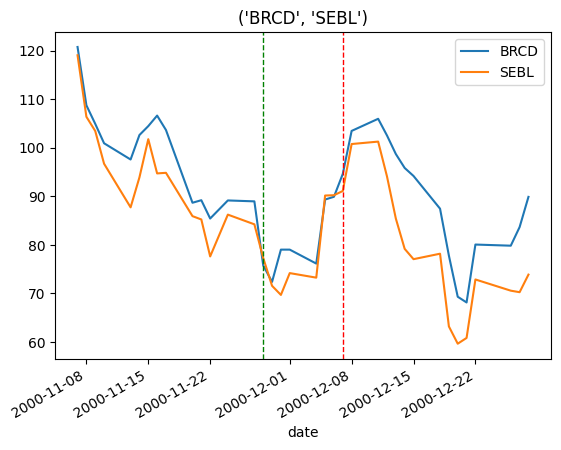

-------------- Finding Periods for Price Data ----------------
215
2000-11-28
2000-12-07
250


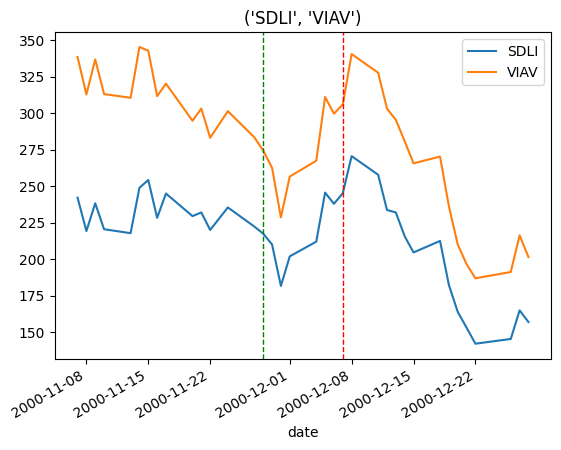

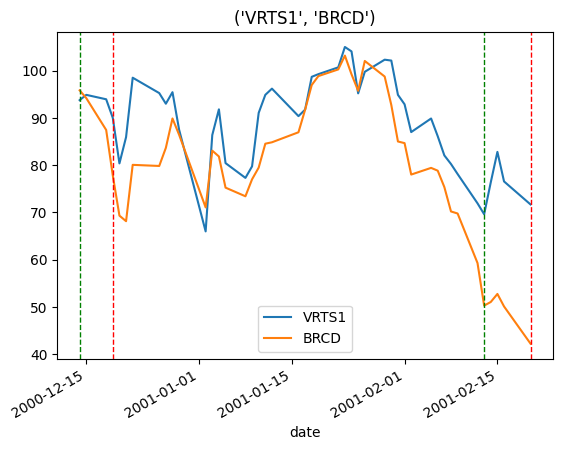

-------------- Finding Periods for Price Data ----------------
231
2000-12-20
2000-12-28
264


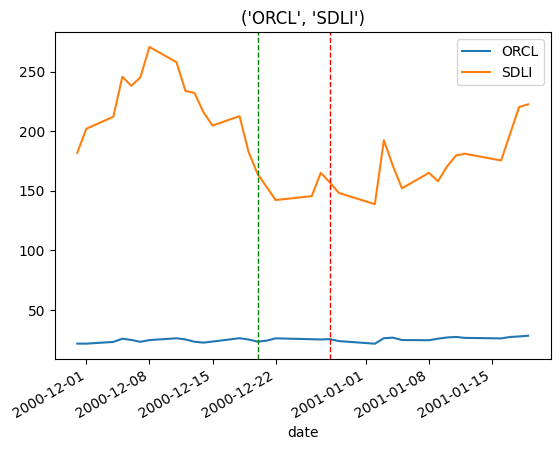

-------------- Finding Periods for Price Data ----------------
265
2001-02-09
2001-03-01
306


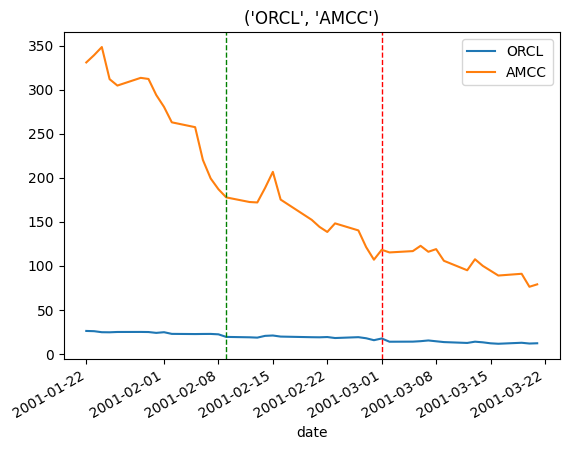

-------------- Finding Periods for Price Data ----------------
255
2001-01-26
2001-02-08
292


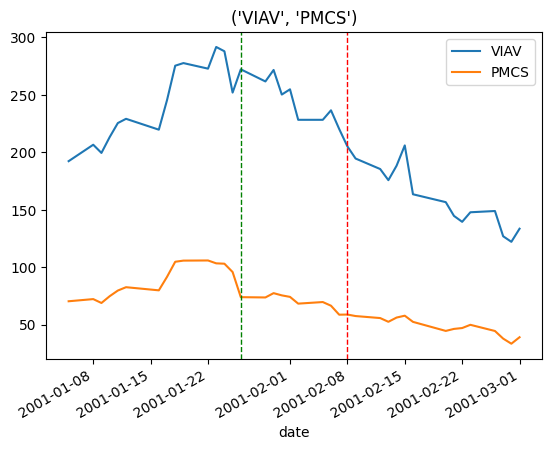

-------------- Finding Periods for Price Data ----------------
271
2001-02-20
2001-03-01
306


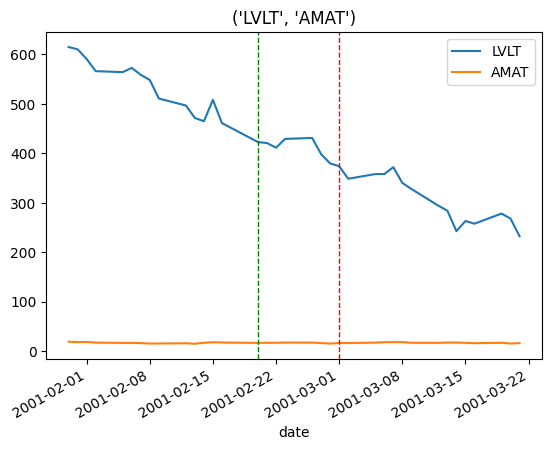

-------------- Finding Periods for Price Data ----------------
280
2001-03-05
2001-03-12
313


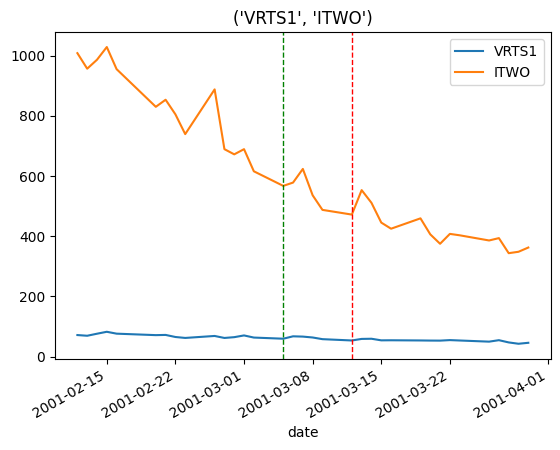

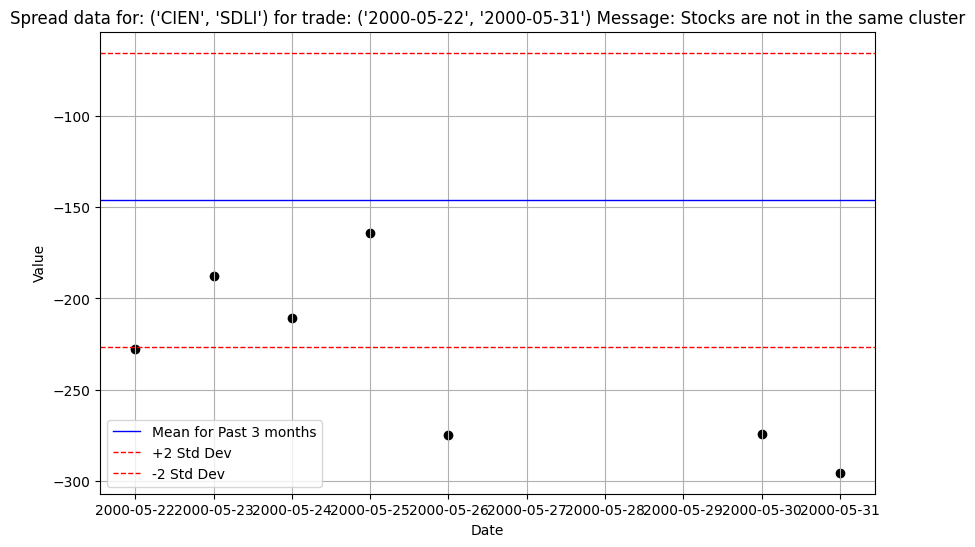

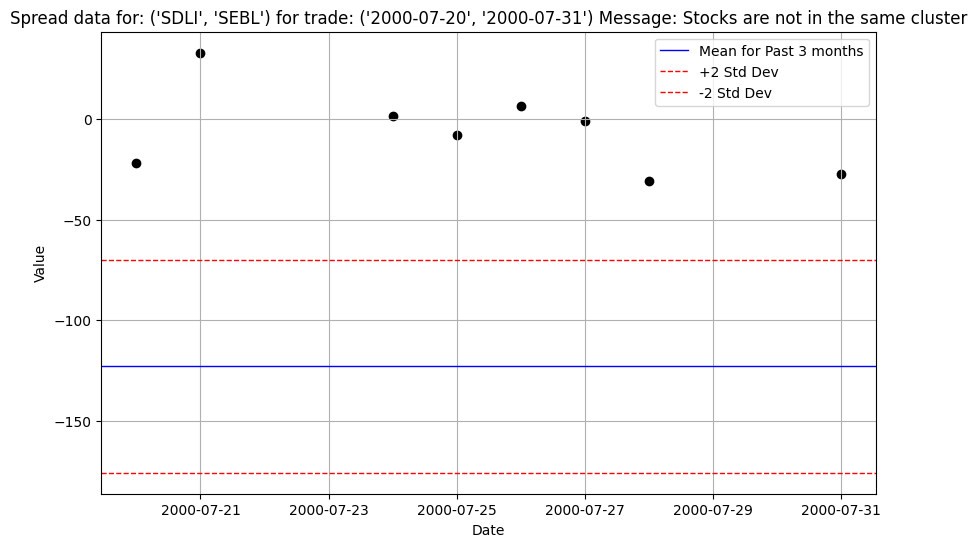

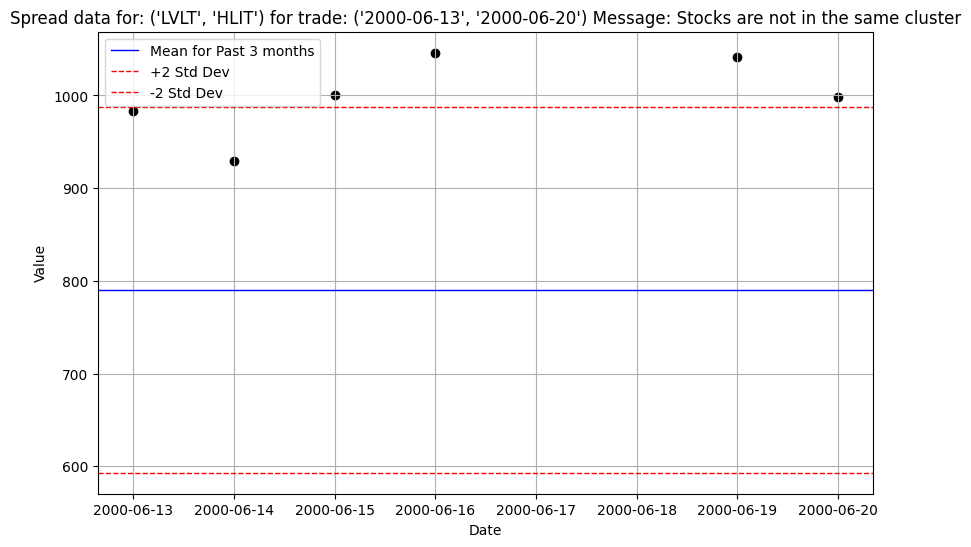

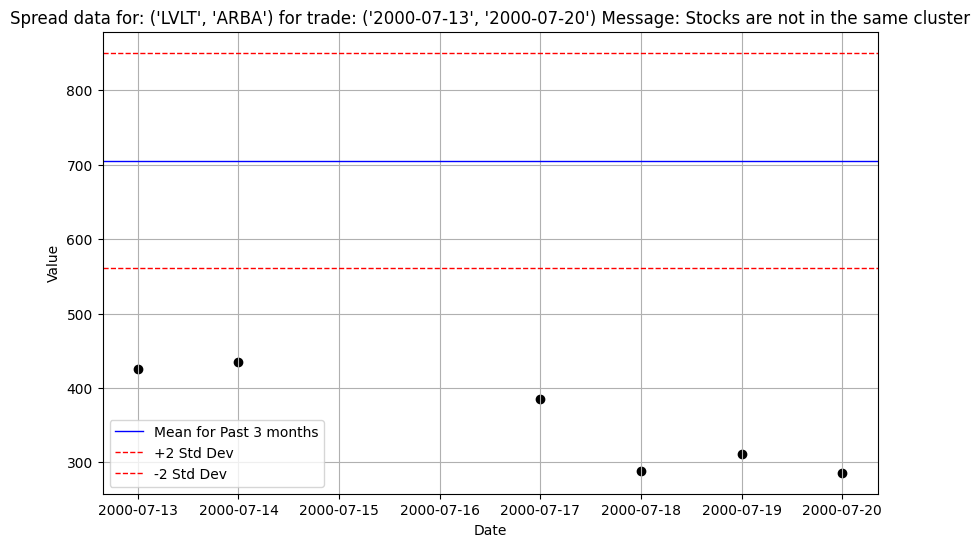

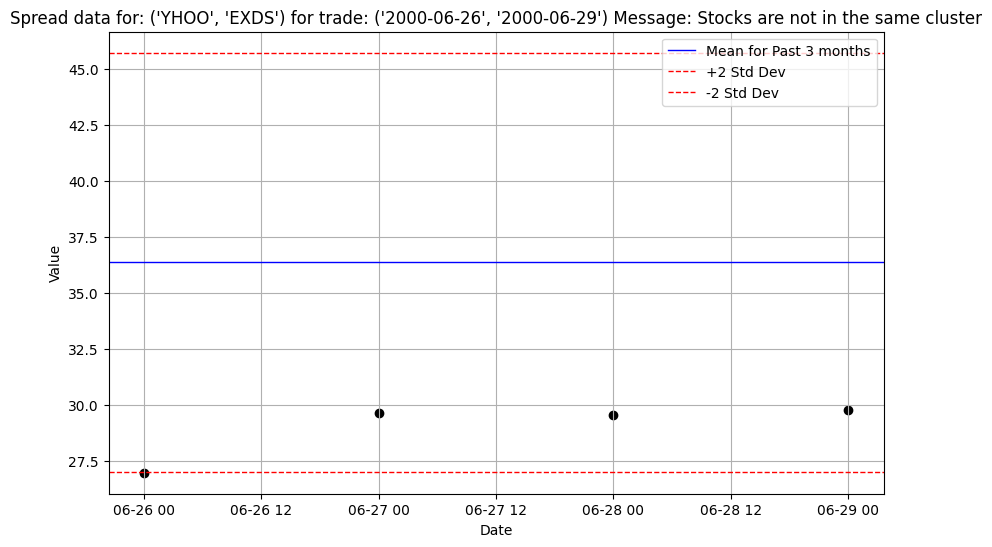

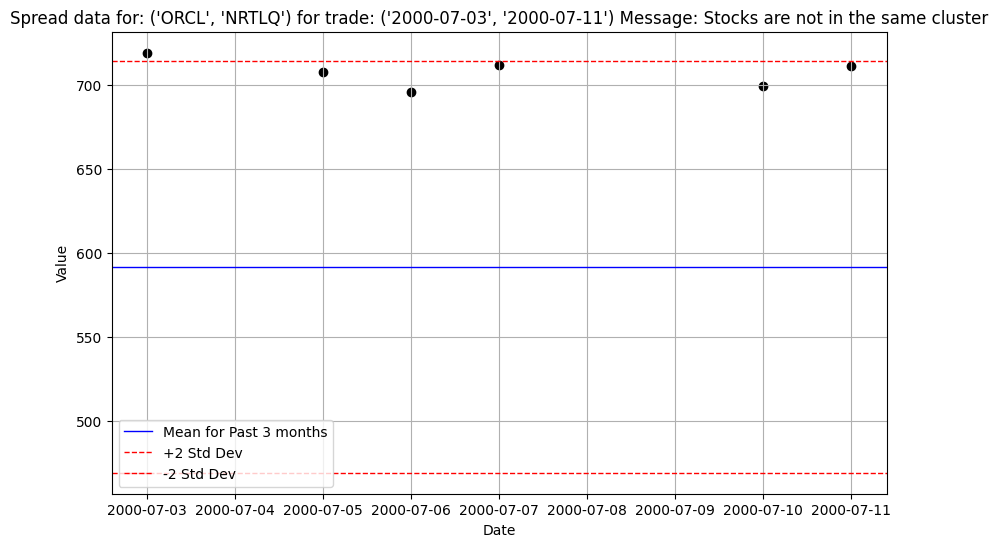

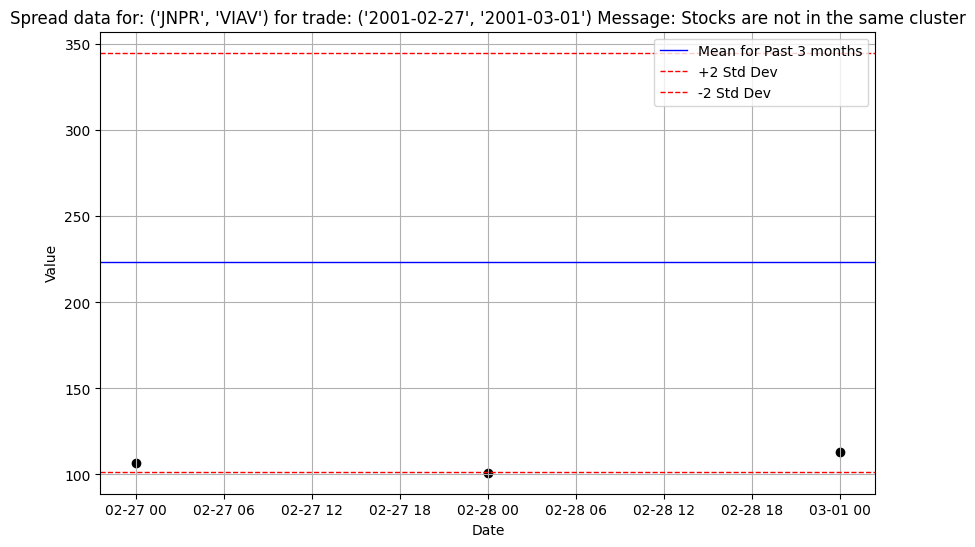

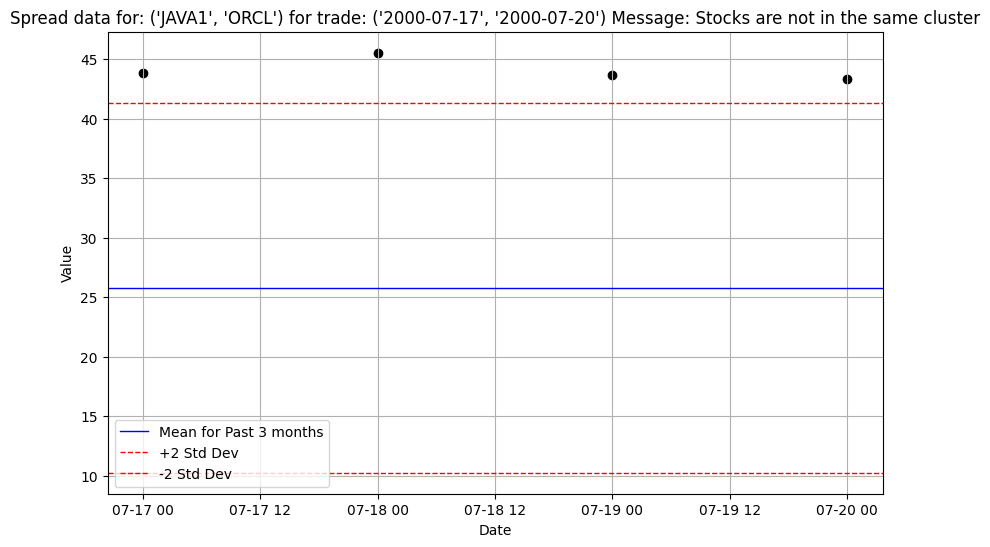

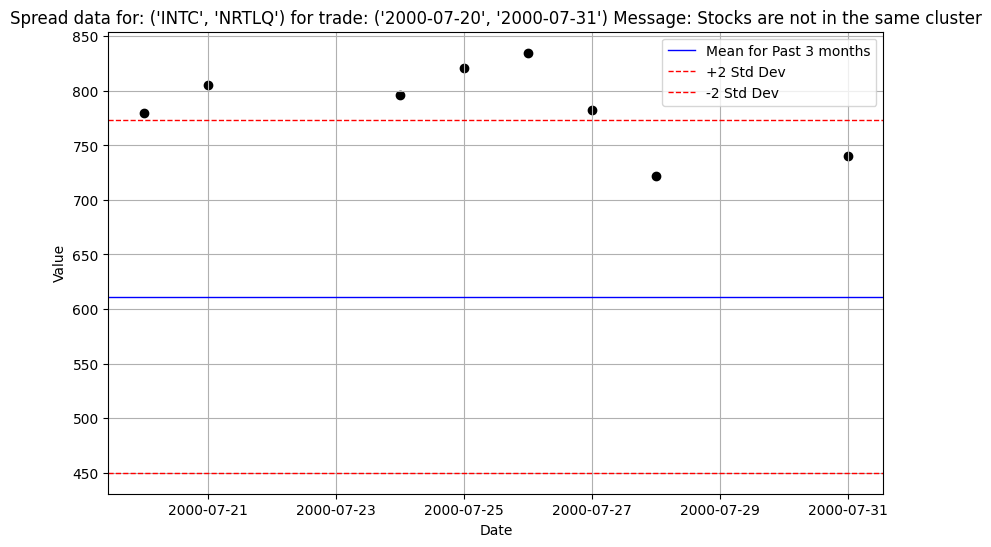

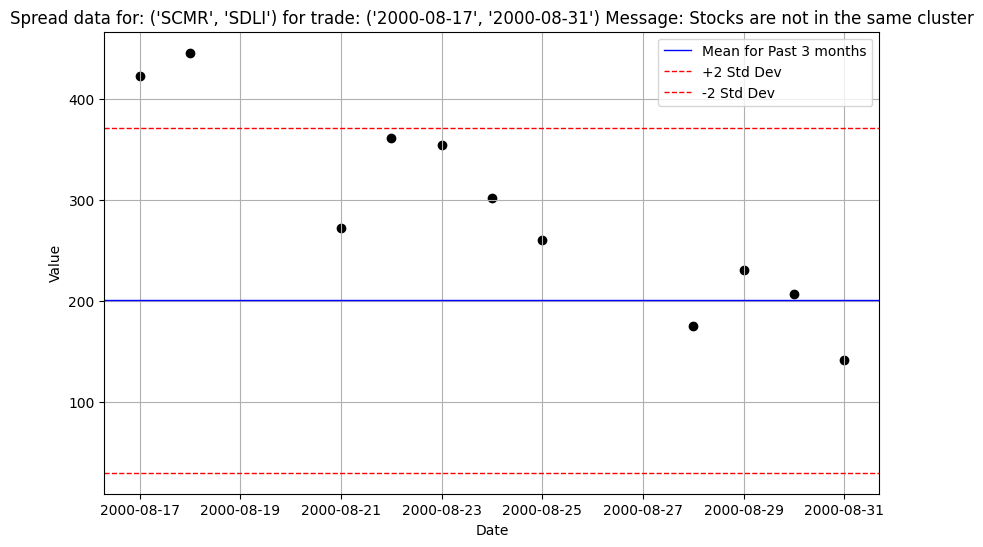

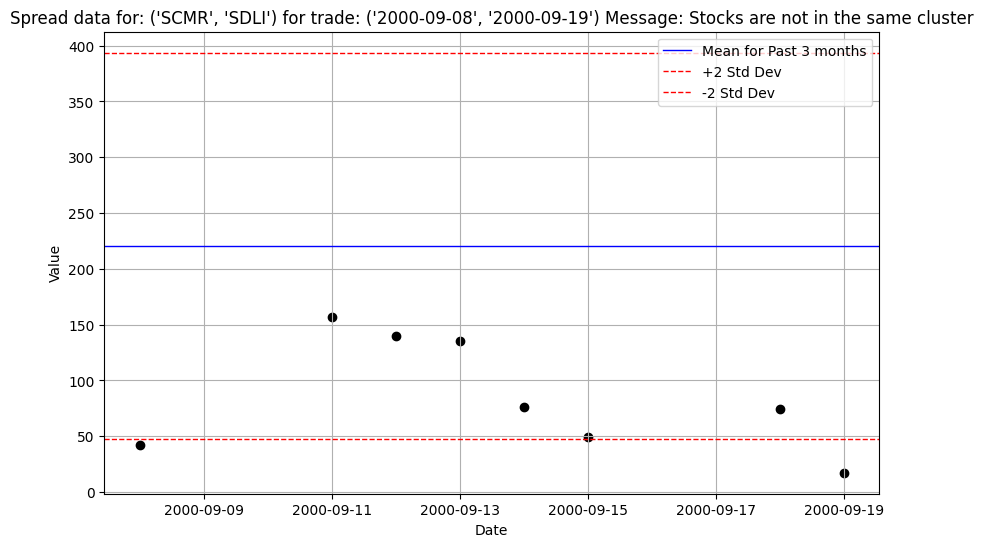

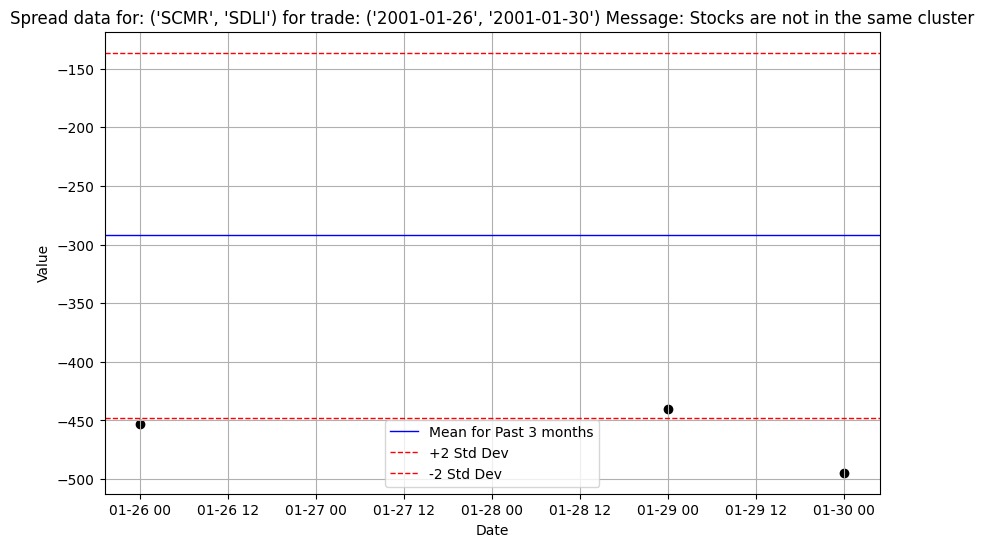

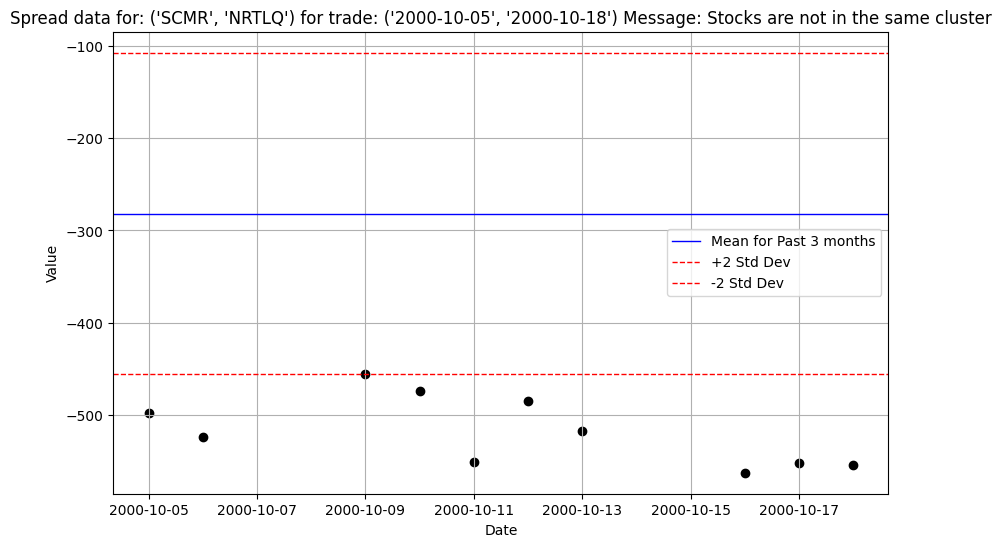

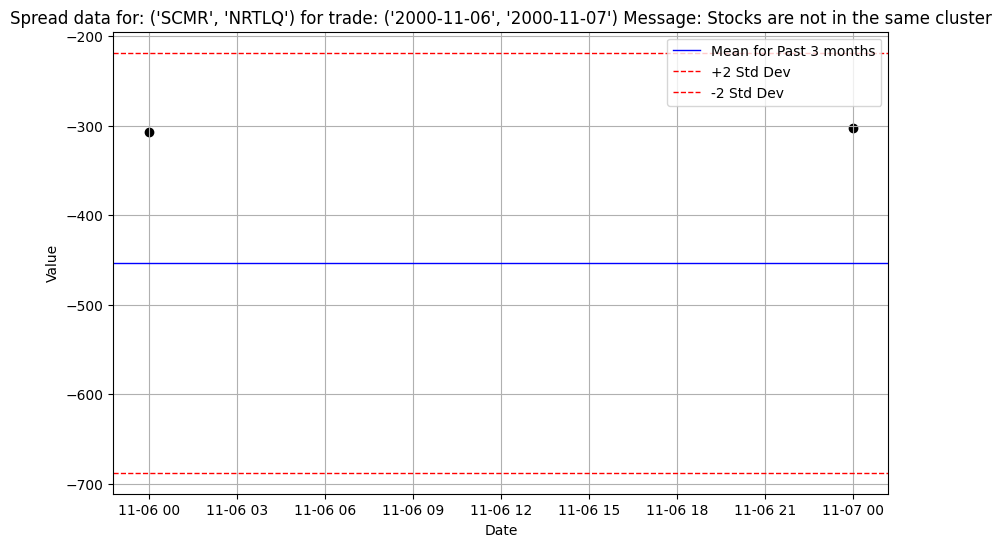

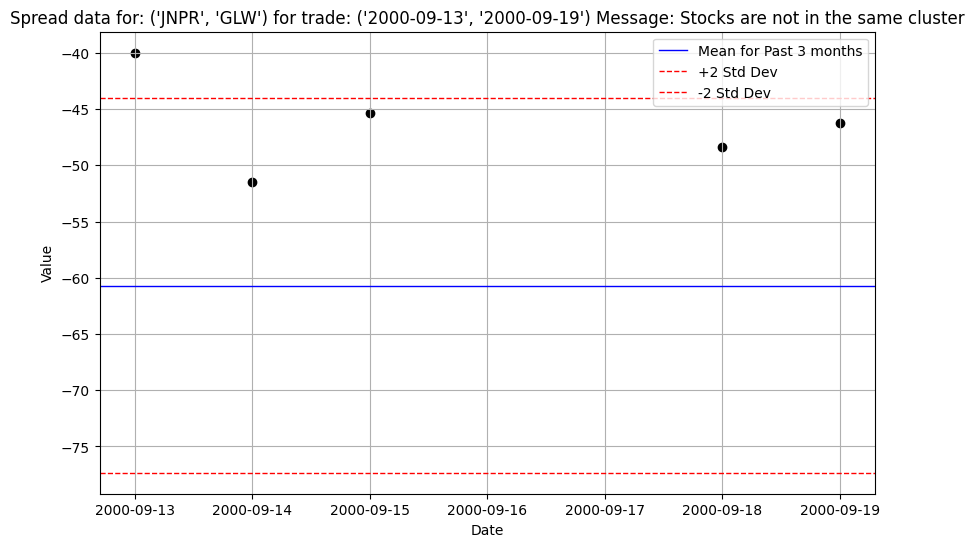

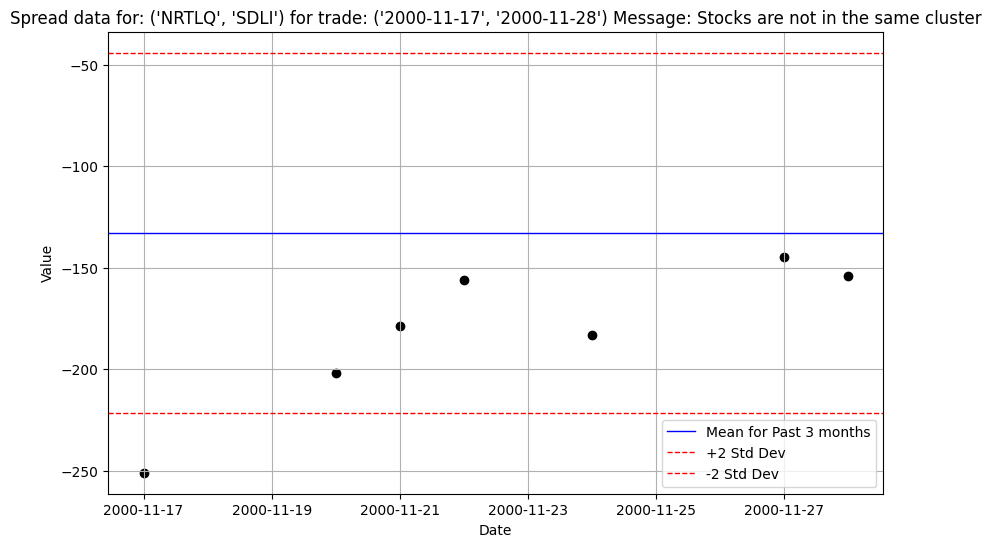

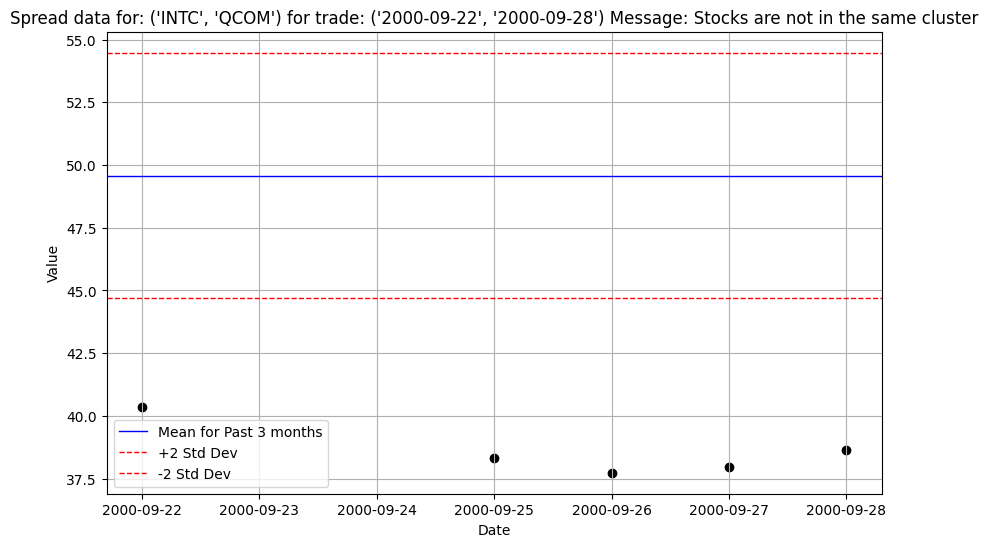

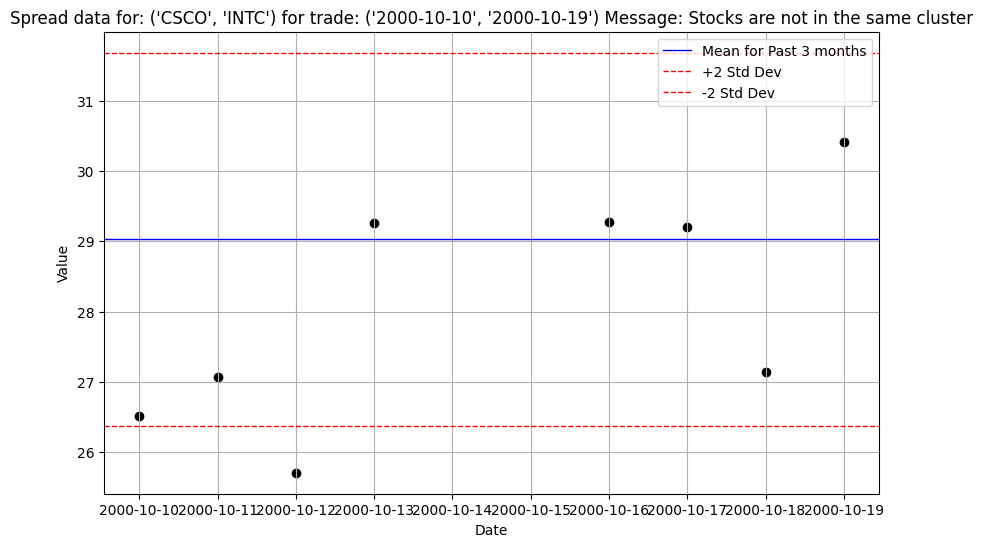

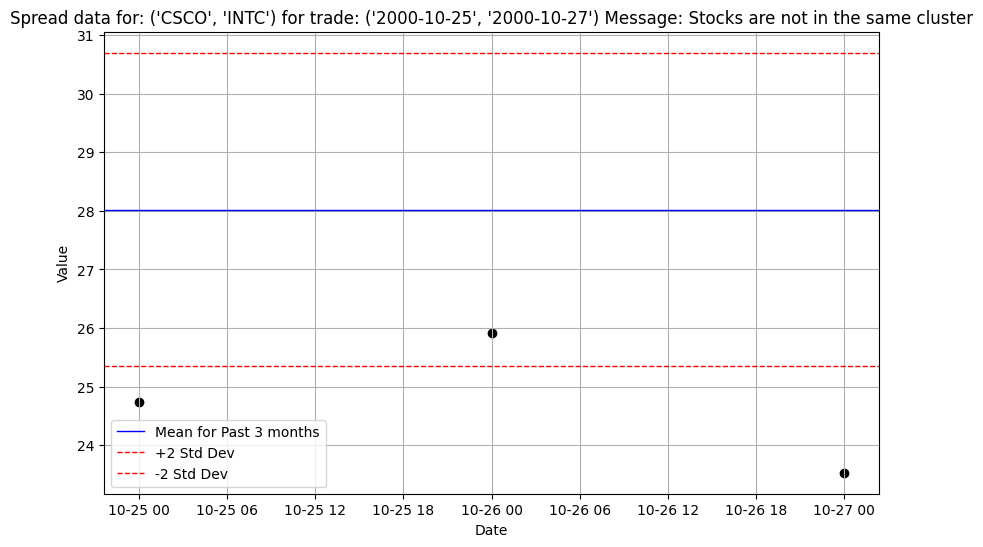

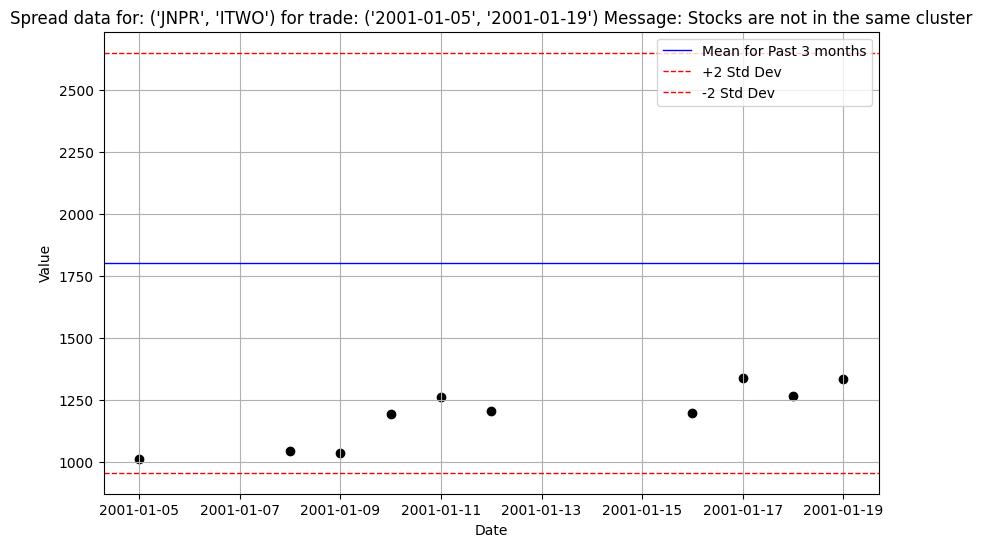

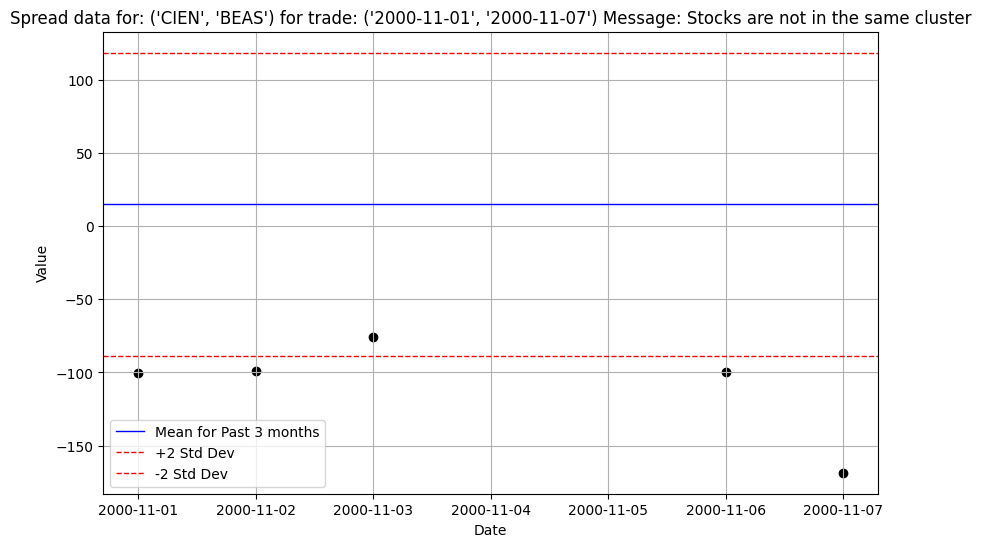

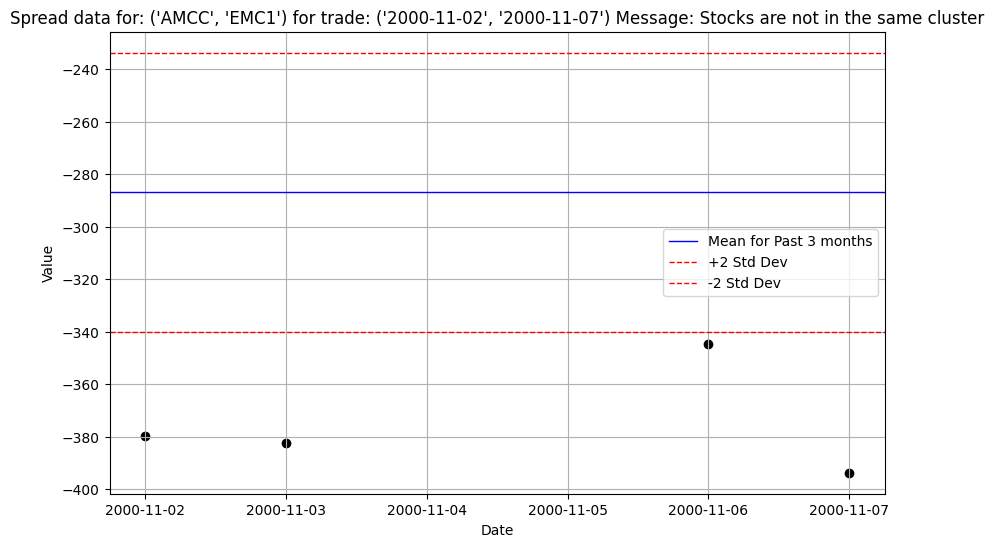

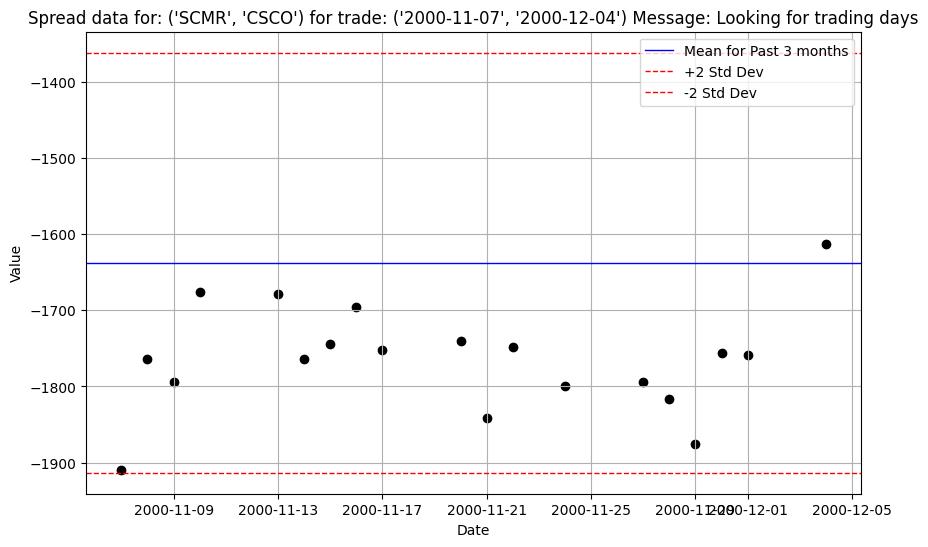

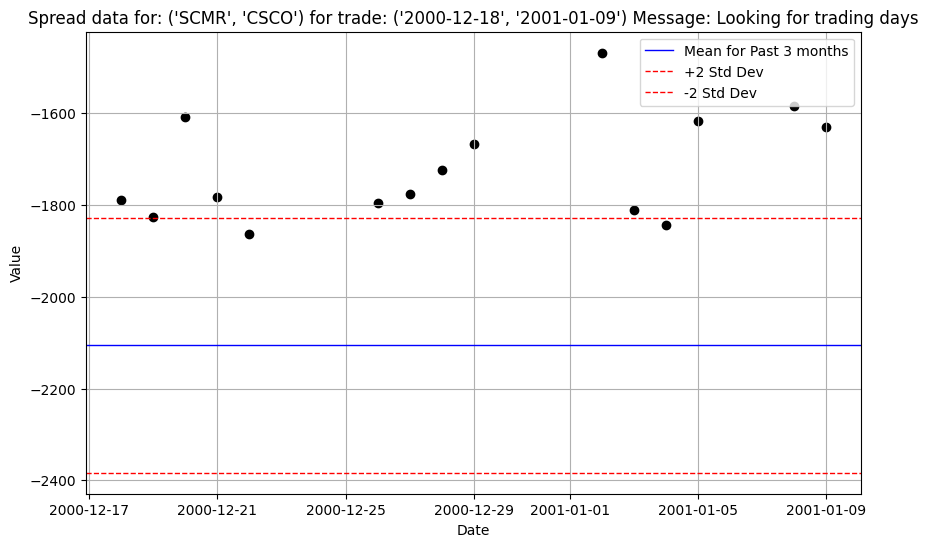

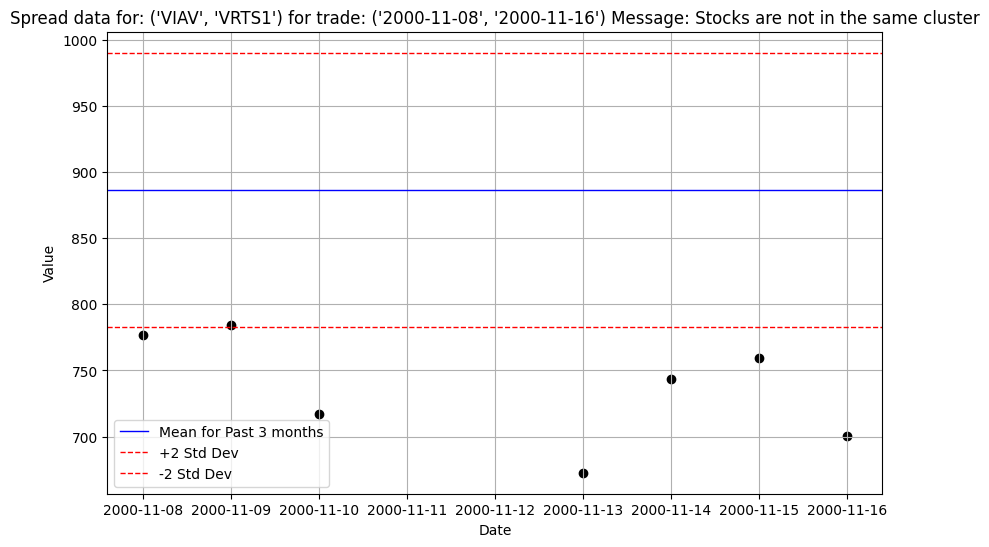

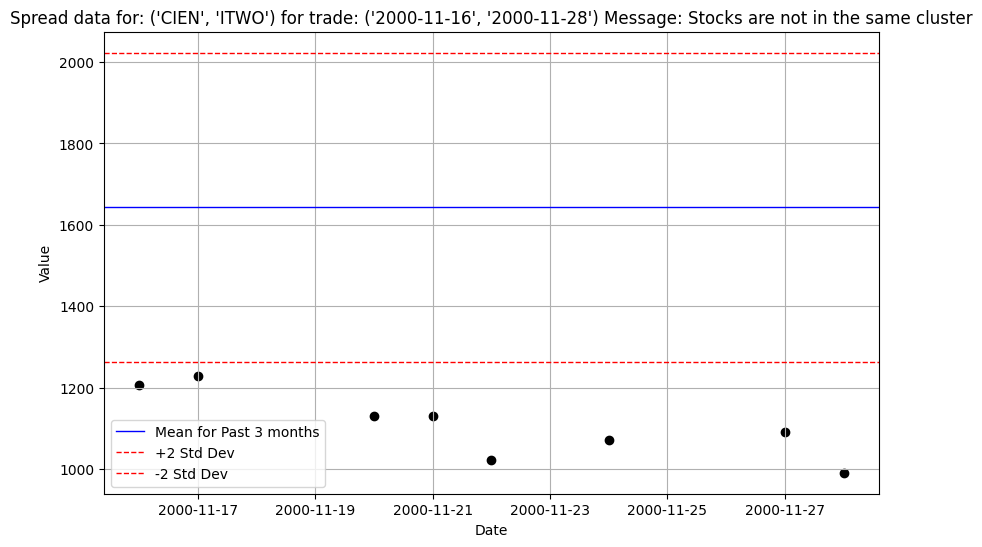

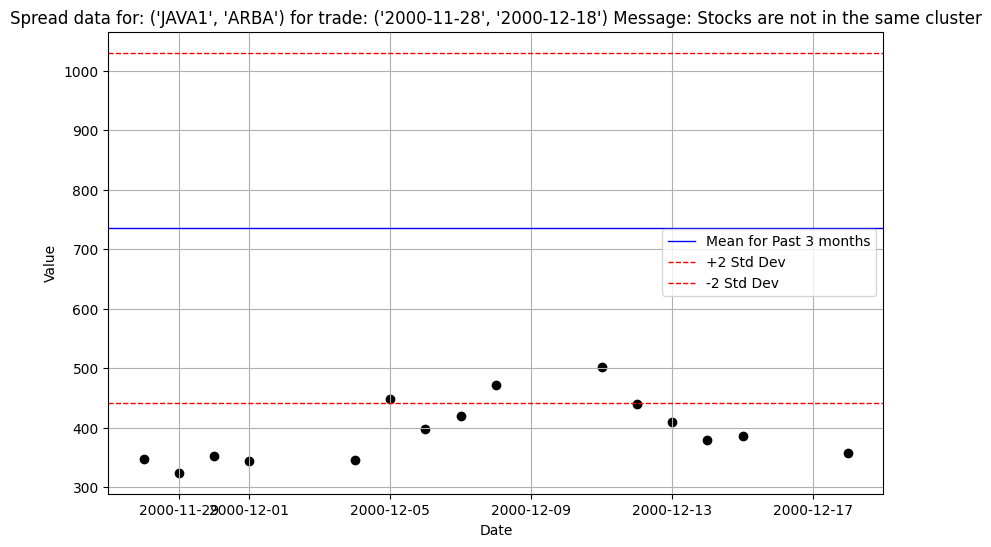

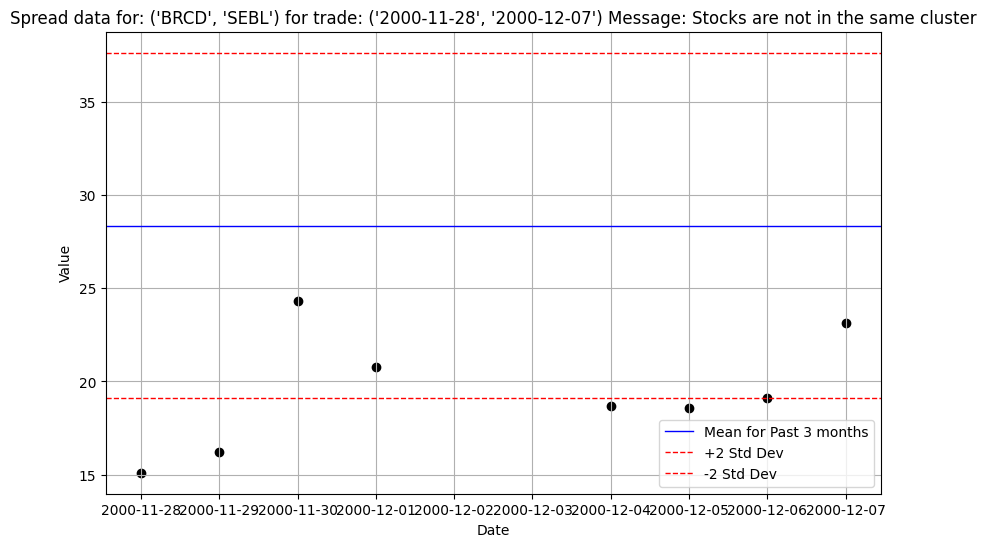

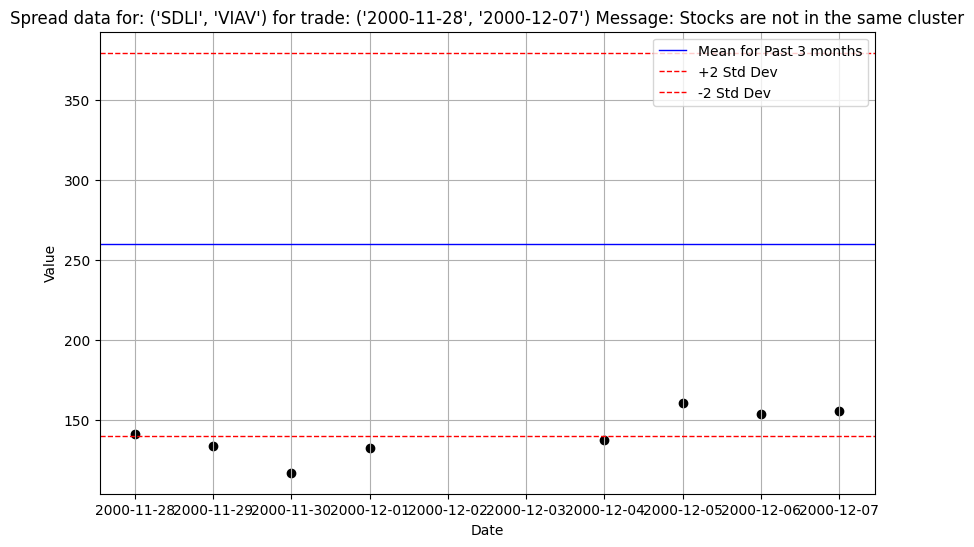

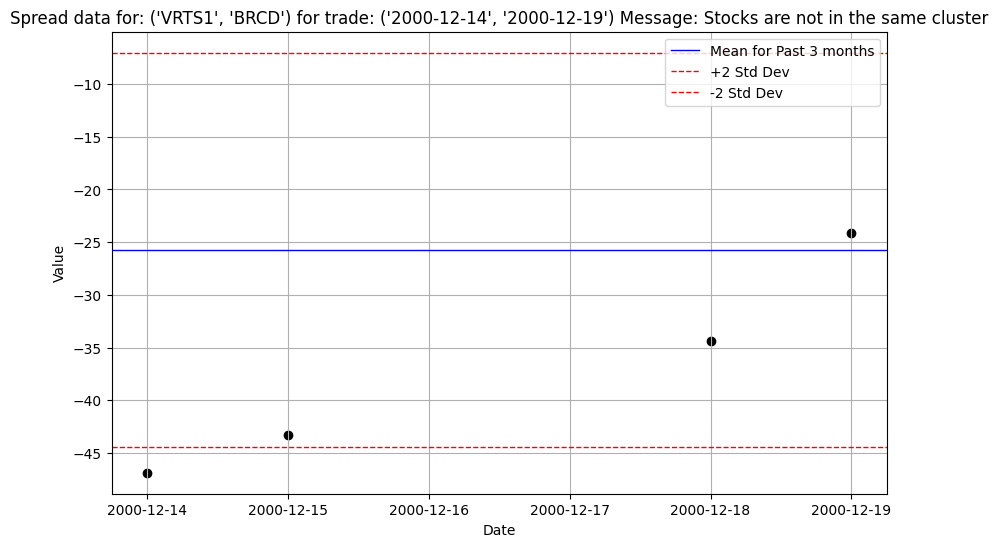

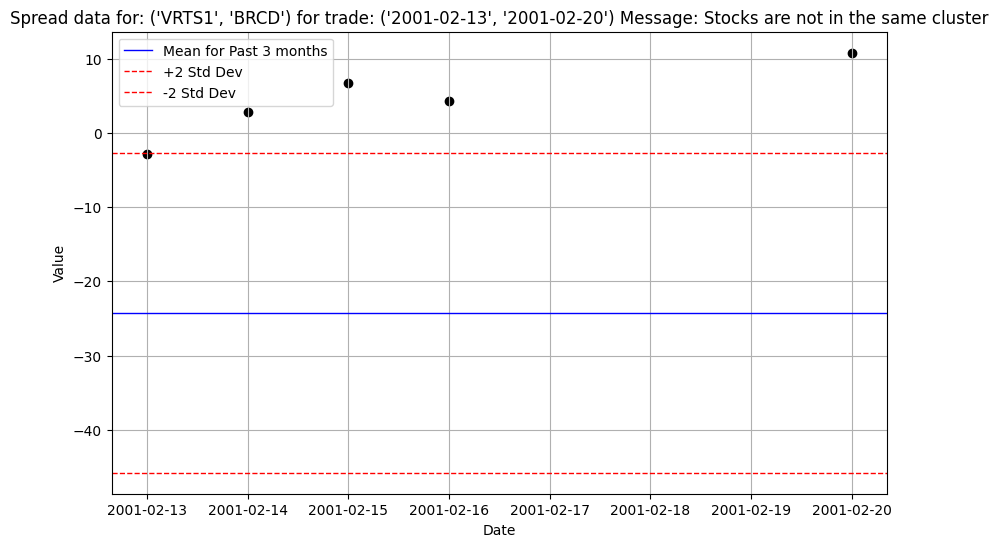

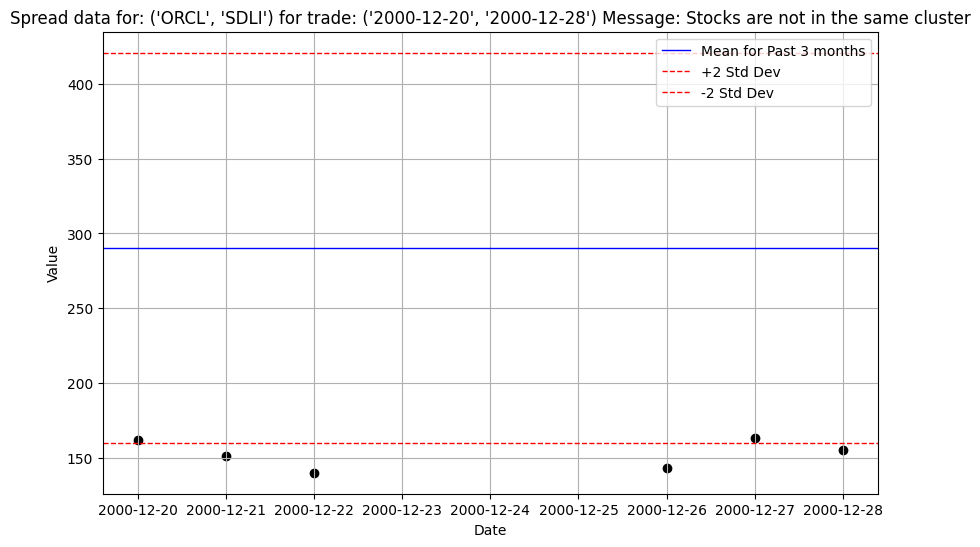

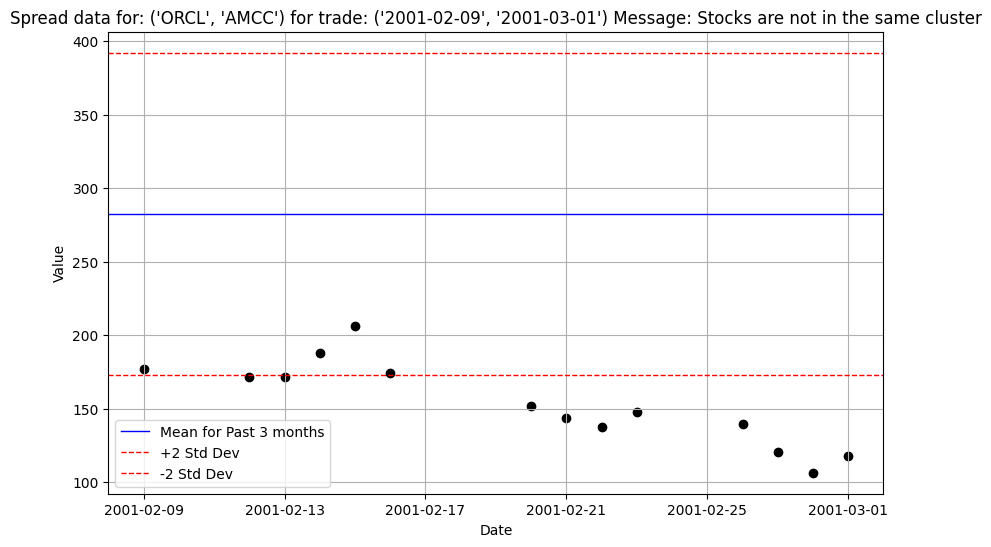

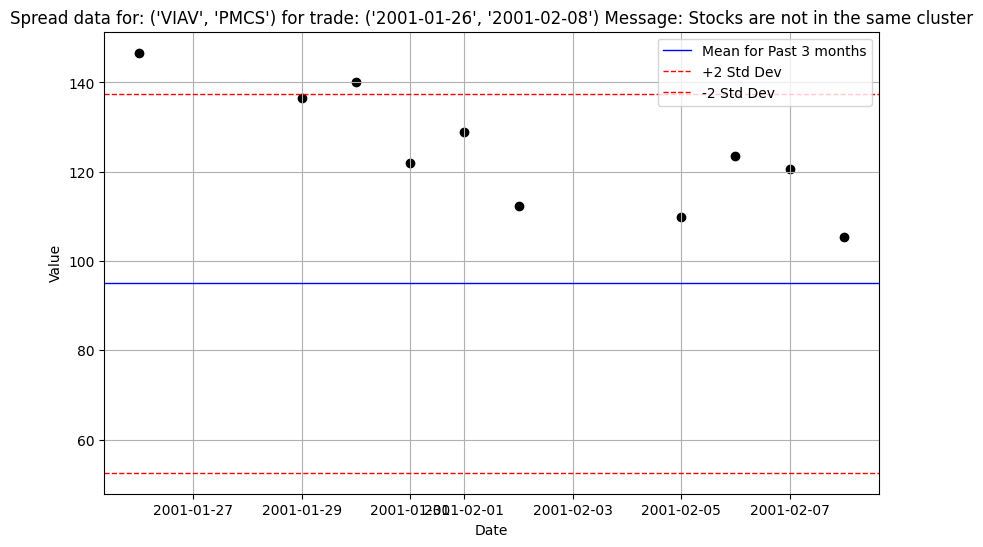

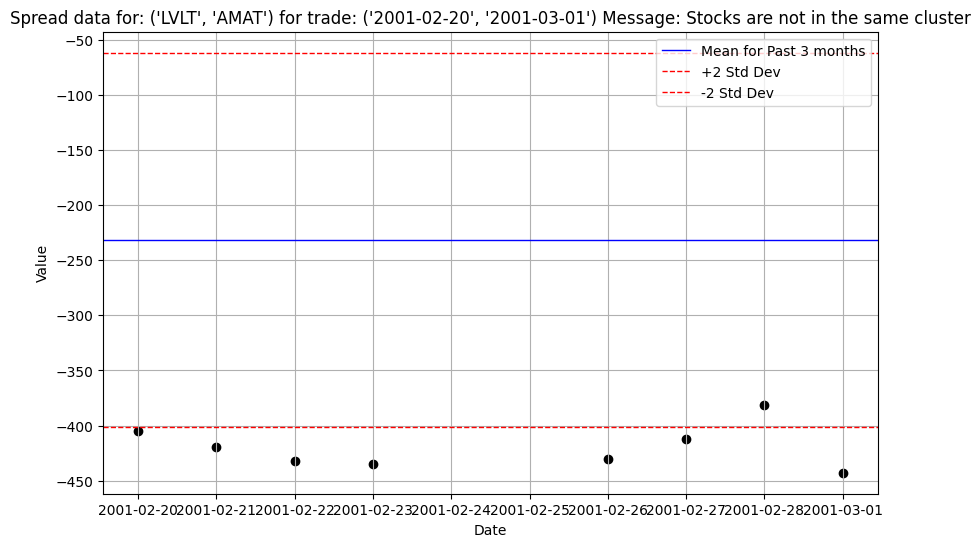

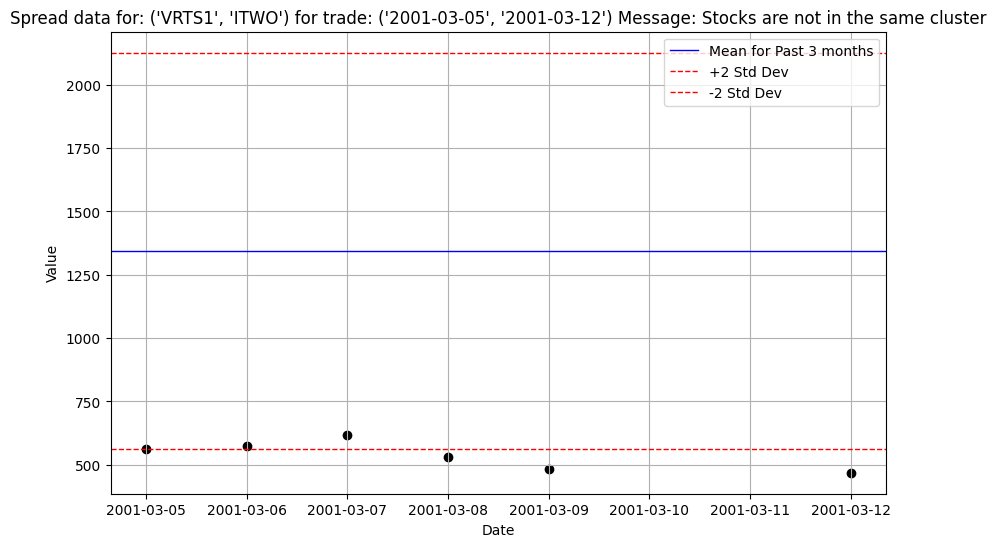

In [81]:
print_all_visualizations(results, end_date)